# Import necessary libraries

In [27]:
!pip install squarify

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Data Loading and Sub Dataset Creating

In [2]:
# Load the dataset
url = 'https://nc.uni-bremen.de/index.php/s/Sj5q8kDdKNa4DoD/download'
df = pd.read_csv(url)

In [3]:
# Define the list of countries for the sub-dataset
countries = ['Bangladesh', 'Nepal', 'Sri Lanka', 'Pakistan', 'India', 'China', 'Indonesia']

# Create a sub-dataset based on the specified countries
sub_df = df[df['country'].isin(countries)]

# Display basic information about the sub-dataset
print("Sub-dataset Information:")
sub_df.info()

# Display first few rows of the sub-dataset
print("\nFirst few rows of the sub-dataset:")
print(sub_df.head())

Sub-dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 2435 entries, 911 to 15507
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   m49_code                  2435 non-null   int64  
 1   country                   2435 non-null   object 
 2   region                    662 non-null    object 
 3   cpc_code                  2435 non-null   object 
 4   commodity                 2435 non-null   object 
 5   year                      2435 non-null   int64  
 6   loss_percentage           2435 non-null   float64
 7   loss_percentage_original  2435 non-null   object 
 8   loss_quantity             241 non-null    object 
 9   activity                  1791 non-null   object 
 10  food_supply_stage         2432 non-null   object 
 11  treatment                 490 non-null    object 
 12  cause_of_loss             280 non-null    object 
 13  sample_size               690 non-null  

In [4]:
# Define columns and missing value replacement category
cols_with_missing = ['treatment', 'cause_of_loss']  # Replace with your list of columns
missing_value_category = 'Not Reported'  # Customize the category name

# Create a copy to avoid modifying the original DataFrame
sub_df_cleaned = sub_df.copy()

# Replace NaN values with the new category in specified columns
for col in cols_with_missing:
    sub_df_cleaned[col] = sub_df_cleaned[col].fillna(missing_value_category)
    
    
# Remove specific words from numerical columns
def clean_numeric_values(value, words_to_remove):
    if pd.isna(value):
        return value
    for word in words_to_remove:
        value = value.replace(word, '')
    return value.strip()


words_to_remove = ['kgs', '%']

# Display information about the cleaned DataFrame
print("Sub-dataset Information (After Creating New Categories):")
print(sub_df_cleaned.info())


Sub-dataset Information (After Creating New Categories):
<class 'pandas.core.frame.DataFrame'>
Index: 2435 entries, 911 to 15507
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   m49_code                  2435 non-null   int64  
 1   country                   2435 non-null   object 
 2   region                    662 non-null    object 
 3   cpc_code                  2435 non-null   object 
 4   commodity                 2435 non-null   object 
 5   year                      2435 non-null   int64  
 6   loss_percentage           2435 non-null   float64
 7   loss_percentage_original  2435 non-null   object 
 8   loss_quantity             241 non-null    object 
 9   activity                  1791 non-null   object 
 10  food_supply_stage         2432 non-null   object 
 11  treatment                 2435 non-null   object 
 12  cause_of_loss             2435 non-null   object 
 13  sample_s

# Create New Column

In [5]:
# Extract unique values from the 'commodity' column
unique_commodities = sub_df_cleaned['commodity'].unique()

# Convert to a list for easier handling
unique_commodities_list = unique_commodities.tolist()

# Print unique values
print(unique_commodities_list)


['Bananas', 'Beans, dry', 'Cabbages', 'Eggplants (aubergines)', 'Tomatoes', 'Pumpkins, squash and gourds', 'Okra', 'Carrots and turnips', 'Leeks and other alliaceous vegetables', 'Papayas', 'Pineapples', 'Edible roots and tubers with high starch or inulin content, n.e.c., fresh', 'Wheat', 'Maize (corn)', 'Rice', 'Potatoes', 'Mixed grain', 'Other fruits, n.e.c.', 'Meat of chickens, fresh or chilled', 'Meat of cattle with the bone, fresh or chilled', 'Cauliflowers and broccoli', 'Green garlic', 'Onions and shallots, green', 'Apples', 'Sorghum', 'Millet', 'Peas, green', 'Mushrooms and truffles', 'Mangoes, guavas and mangosteens', 'Other tropical and subtropical fruits, n.e.c.', 'Other citrus fruit, n.e.c.', 'Grapes', 'Cashew nuts, in shell', 'Areca nuts', 'Soya beans', 'Groundnuts, excluding shelled', 'Cottonseed', 'Mustard seed', 'Sunflower seed', 'Safflower seed', 'Coconuts, in shell', 'Pepper (<i>Piper</i> spp.), raw', 'Chillies and peppers, dry (<i>Capsicum</i> spp., <i>Pimenta</i> sp

In [6]:
#Create Commodity_Group column
# List of commodities
commodity = [
    'Rice, milled', 'Wheat', 'Maize (corn)', 'Rice', 'Sorghum', 'Millet', 'Tomatoes', 'Beans, dry', 
    'Cauliflowers and broccoli', 'Cucumbers and gherkins', 'Other beans, green', 'Potatoes', 'Bananas', 
    'Plantains and cooking bananas', 'Meat of cattle with the bone, fresh or chilled', 'Mixed grain', 
    'Snails, fresh, chilled, frozen, dried, salted or in brine, except sea snails', 'Other fruits, n.e.c.', 
    'Cabbages', 'Eggplants (aubergines)', 'Pumpkins, squash and gourds', 'Okra', 'Carrots and turnips', 
    'Leeks and other alliaceous vegetables', 'Papayas', 'Pineapples', 'Edible roots and tubers with high starch or inulin content, n.e.c., fresh', 
    'Raw milk of cattle', 'Hen eggs in shell, fresh', 'Pears', 'Meat of chickens, fresh or chilled', 
    'Green garlic', 'Onions and shallots, green', 'Apples', 'Mangoes, guavas and mangosteens', 'Spinach', 
    'Cantaloupes and other melons', 'Other vegetables, fresh n.e.c.', 'Avocados', 'Chillies and peppers, dry (<i>Capsicum</i> spp., <i>Pimenta</i> spp.), raw', 
    'Fonio', 'Cassava, fresh', 'Oranges', 'Pepper (<i>Piper</i> spp.), raw', 'Peas, green', 'Peas, dry', 'Barley', 
    'Cow peas, dry', 'Quinoa', 'Oats', 'Cassava, dry', 'Flour of triticale', 'Broad beans and horse beans, dry', 
    'Lentils, dry', 'Other pulses n.e.c.', 'Other tropical and subtropical fruits, n.e.c.', 'Rye', 
    'Dairy products n.e.c.', 'Strawberries', 'Lettuce and chicory', 'Cheese from whole cow milk', 
    'Uncooked pasta, not stuffed or otherwise prepared', 'Rape or colza seed', 'Soya bean oil', 'Sunflower-seed oil, crude', 
    'Yams', 'Groundnuts, shelled', 'Flour of cassava', 'Cattle', 'Groundnuts, excluding shelled', 'Grapes', 
    'Hazelnuts, in shell', 'Walnuts, in shell', 'Meat of goat, fresh or chilled', 'Eggs, dried', 'Soya beans', 
    'Mushrooms and truffles', 'Other citrus fruit, n.e.c.', 'Cashew nuts, in shell', 'Areca nuts', 'Cottonseed', 
    'Mustard seed', 'Sunflower seed', 'Safflower seed', 'Coconuts, in shell', 'Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw', 
    'Other stimulant, spice and aromatic crops, n.e.c.', 'Chick peas, dry', 'Pigeon peas, dry', 'Sugar cane', 
    'Tapioca of cassava', 'Sheep', 'Meat of goat, fresh or chilled (indigenous)', 'Chillies and peppers, green (<i>Capsicum</i> spp. and <i>Pimenta</i> spp.)', 
    'Sweet corn, frozen', 'Watermelons', 'Dates', 'Figs', 'Cherries', 'Other stone fruits', 'Kiwi fruit', 'Persimmons', 
    'Almonds, in shell', 'Pistachios, in shell', 'Other legumes, for forage', 'Wine', 'Lemons and limes', 
    'Meat of pig with the bone, fresh or chilled', 'Tangerines, mandarins, clementines', 'Sweet potatoes', 
    'Edible roots and tubers with high starch or inulin content, n.e.c., dry', 'Plums and sloes', 'Apricots', 
    'Peaches and nectarines', 'Broad beans and horse beans, green', 'Cocoa beans', 'Camels', 'Flour of buckwheat', 
    'Sugar beet', 'Other pome fruits', 'Raspberries', 'Blueberries', 'Swedes, for forage', 'Meat of sheep, fresh or chilled', 
    'Sesame seed', 'Bambara beans, dry', 'Asparagus', 'Artichokes', 'Green corn (maize)', 'Pomelos and grapefruits', 
    'Grapefruit juice', 'Cranberries', 'Canned mushrooms', 'Orange juice', 'Pineapple juice', 'Grape juice', 
    'Apple juice', 'Sweet corn, prepared or preserved', 'Plums, dried', 'Pig meat, cuts, salted, dried or smoked (bacon and ham)', 
    'Goats', 'Olives', 'Raisins', 'Juice of lemon', 'Juice of citrus fruit n.e.c.', 'Vegetable products, fresh or dry n.e.c.', 
    'Sugar and syrups n.e.c.'
]

# Commodity groups mapping
commodity_group = {
    "Cereals & Pulses": [
        'Rice, milled', 'Wheat', 'Maize (corn)', 'Rice', 'Sorghum', 'Millet', 'Beans, dry', 'Other beans, green', 
        'Peas, green', 'Peas, dry', 'Barley', 'Cow peas, dry', 'Quinoa', 'Oats', 'Broad beans and horse beans, dry', 
        'Lentils, dry', 'Other pulses n.e.c.', 'Rye', 'Chick peas, dry', 'Pigeon peas, dry', 'Fonio'
    ],
    "Fruits & Vegetables": [
        'Tomatoes', 'Cauliflowers and broccoli', 'Cucumbers and gherkins', 'Potatoes', 'Bananas', 'Plantains and cooking bananas', 
        'Other fruits, n.e.c.', 'Cabbages', 'Eggplants (aubergines)', 'Pumpkins, squash and gourds', 'Okra', 'Carrots and turnips', 
        'Leeks and other alliaceous vegetables', 'Papayas', 'Pineapples', 'Pears', 'Green garlic', 'Onions and shallots, green', 
        'Apples', 'Mangoes, guavas and mangosteens', 'Spinach', 'Cantaloupes and other melons', 'Other vegetables, fresh n.e.c.', 
        'Avocados', 'Chillies and peppers, dry (<i>Capsicum</i> spp., <i>Pimenta</i> spp.), raw', 'Oranges', 
        'Pepper (<i>Piper</i> spp.), raw', 'Other tropical and subtropical fruits, n.e.c.', 'Strawberries', 'Lettuce and chicory', 
        'Grapes', 'Hazelnuts, in shell', 'Walnuts, in shell', 'Mushrooms and truffles', 'Other citrus fruit, n.e.c.', 
        'Cashew nuts, in shell', 'Areca nuts', 'Coconuts, in shell', 'Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw', 
        'Other stimulant, spice and aromatic crops, n.e.c.', 'Watermelons', 'Dates', 'Figs', 'Cherries', 'Other stone fruits', 
        'Kiwi fruit', 'Persimmons', 'Almonds, in shell', 'Pistachios, in shell', 'Other legumes, for forage', 'Lemons and limes', 
        'Tangerines, mandarins, clementines', 'Sweet potatoes', 'Plums and sloes', 'Apricots', 'Peaches and nectarines', 
        'Broad beans and horse beans, green', 'Other pome fruits', 'Raspberries', 'Blueberries', 'Asparagus', 'Artichokes', 
        'Green corn (maize)', 'Pomelos and grapefruits', 'Canned mushrooms', 'Olives', 'Vegetable products, fresh or dry n.e.c.'
    ],
    "Roots, Tubers & Oil crops": [
        'Edible roots and tubers with high starch or inulin content, n.e.c., fresh', 'Cassava, fresh', 'Soya bean oil', 
        'Sunflower-seed oil, crude', 'Yams', 'Groundnuts, shelled', 'Flour of cassava', 'Groundnuts, excluding shelled', 
        'Cottonseed', 'Mustard seed', 'Sunflower seed', 'Safflower seed', 'Edible roots and tubers with high starch or inulin content, n.e.c., dry', 
        'Cassava, dry', 'Sugar cane', 'Tapioca of cassava', 'Flour of buckwheat', 'Sugar beet', 'Sesame seed', 'Bambara beans, dry'
    ],
    "Animal Products": [
        'Meat of cattle with the bone, fresh or chilled', 'Snails, fresh, chilled, frozen, dried, salted or in brine, except sea snails', 
        'Raw milk of cattle', 'Hen eggs in shell, fresh', 'Meat of chickens, fresh or chilled', 'Cheese from whole cow milk', 
        'Eggs, dried', 'Meat of goat, fresh or chilled', 'Meat of goat, fresh or chilled (indigenous)', 'Meat of pig with the bone, fresh or chilled', 
        'Meat of sheep, fresh or chilled', 'Pig meat, cuts, salted, dried or smoked (bacon and ham)', 'Cattle', 'Sheep', 'Goats', 'Camels'
    ],
    #"Fish Products": [],  # No specific fish products in the list
    "Other": [
        'Mixed grain', 'Dairy products n.e.c.', 'Uncooked pasta, not stuffed or otherwise prepared', 'Flour of triticale', 
        'Wine', 'Cocoa beans', 'Grapefruit juice', 'Cranberries', 'Orange juice', 'Pineapple juice', 'Grape juice', 
        'Apple juice', 'Sweet corn, frozen', 'Sweet corn, prepared or preserved', 'Plums, dried', 'Juice of lemon', 
        'Juice of citrus fruit n.e.c.', 'Sugar and syrups n.e.c.'
    ]
}


# Create a new column named 'commodity_group' based on mapping
sub_df_cleaned['commodity_group'] = sub_df_cleaned['commodity'].apply(lambda x: next((group for group, items in commodity_group.items() if x in items), 'Other'))

# Handle cases where the original commodity doesn't map to any defined group (assign to 'Other')
sub_df_cleaned['commodity_group'] = sub_df_cleaned['commodity_group'].fillna('Other')






In [7]:
print(sub_df_cleaned.info())
sub_df_cleaned.head()
# Extract unique years from the 'year' column
unique_years = sub_df_cleaned['year'].unique()

# Sort the years (optional, for readability)
unique_years = sorted(unique_years)

# Display the unique years
print("Unique years in the dataset:", unique_years)


<class 'pandas.core.frame.DataFrame'>
Index: 2435 entries, 911 to 15507
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   m49_code                  2435 non-null   int64  
 1   country                   2435 non-null   object 
 2   region                    662 non-null    object 
 3   cpc_code                  2435 non-null   object 
 4   commodity                 2435 non-null   object 
 5   year                      2435 non-null   int64  
 6   loss_percentage           2435 non-null   float64
 7   loss_percentage_original  2435 non-null   object 
 8   loss_quantity             241 non-null    object 
 9   activity                  1791 non-null   object 
 10  food_supply_stage         2432 non-null   object 
 11  treatment                 2435 non-null   object 
 12  cause_of_loss             2435 non-null   object 
 13  sample_size               690 non-null    object 
 14  method_dat

In [8]:
specific_columns = ['country', 'commodity','commodity_group', 'year', 'loss_percentage', 'loss_percentage_original',
    'loss_quantity', 'activity', 'food_supply_stage', 'treatment', 'cause_of_loss']
df_selected = sub_df_cleaned[specific_columns]

# Display the first few rows of the selected columns
df_selected.head()


,country,commodity,commodity_group,year,loss_percentage,loss_percentage_original,loss_quantity,activity,food_supply_stage,treatment,cause_of_loss
911,Sri Lanka,Bananas,Fruits & Vegetables,2018,14.41,14.41%,NaN,Retailing,Retail,Not Reported,Not Reported
912,Sri Lanka,Bananas,Fruits & Vegetables,2018,1.00,1%,NaN,Harvesting,Harvest,Not Reported,Not Reported
913,Sri Lanka,Bananas,Fruits & Vegetables,2018,3.00,3%,NaN,Harvesting,Harvest,using improved handling and marketing practices,Not Reported
914,Sri Lanka,Bananas,Fruits & Vegetables,2018,5.40,5.4%,NaN,Wholesale,Wholesale,Not Reported,Not Reported
915,Sri Lanka,Bananas,Fruits & Vegetables,2018,11.95,11.95%,NaN,Retailing,Retail,using improved handling and marketing practices,Not Reported


In [9]:
def clean_inf_values(df):
    """Convert inf values to NaN in a DataFrame."""
    return df.replace([np.inf, -np.inf], np.nan)

# Apply the function to your DataFrame
sub_df_cleaned = clean_inf_values(df_selected)
sub_df_cleaned.head()


,country,commodity,commodity_group,year,loss_percentage,loss_percentage_original,loss_quantity,activity,food_supply_stage,treatment,cause_of_loss
911,Sri Lanka,Bananas,Fruits & Vegetables,2018,14.41,14.41%,NaN,Retailing,Retail,Not Reported,Not Reported
912,Sri Lanka,Bananas,Fruits & Vegetables,2018,1.00,1%,NaN,Harvesting,Harvest,Not Reported,Not Reported
913,Sri Lanka,Bananas,Fruits & Vegetables,2018,3.00,3%,NaN,Harvesting,Harvest,using improved handling and marketing practices,Not Reported
914,Sri Lanka,Bananas,Fruits & Vegetables,2018,5.40,5.4%,NaN,Wholesale,Wholesale,Not Reported,Not Reported
915,Sri Lanka,Bananas,Fruits & Vegetables,2018,11.95,11.95%,NaN,Retailing,Retail,using improved handling and marketing practices,Not Reported


# Exploratory Data Analysis (EDA) and Visualization

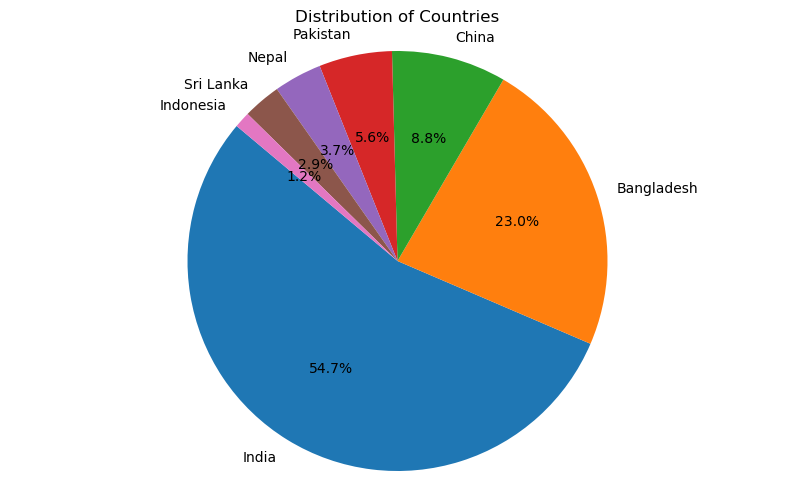

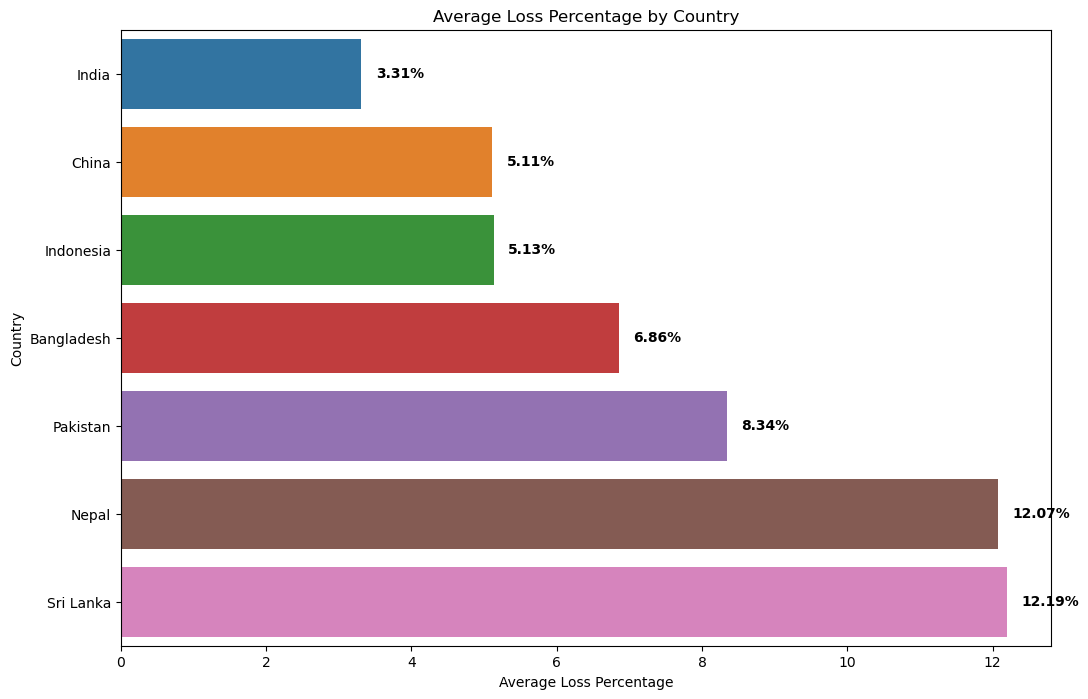

Sri Lanka: 12.19%
Nepal: 12.07%
Pakistan: 8.34%
Bangladesh: 6.86%
Indonesia: 5.13%
China: 5.11%
India: 3.31%


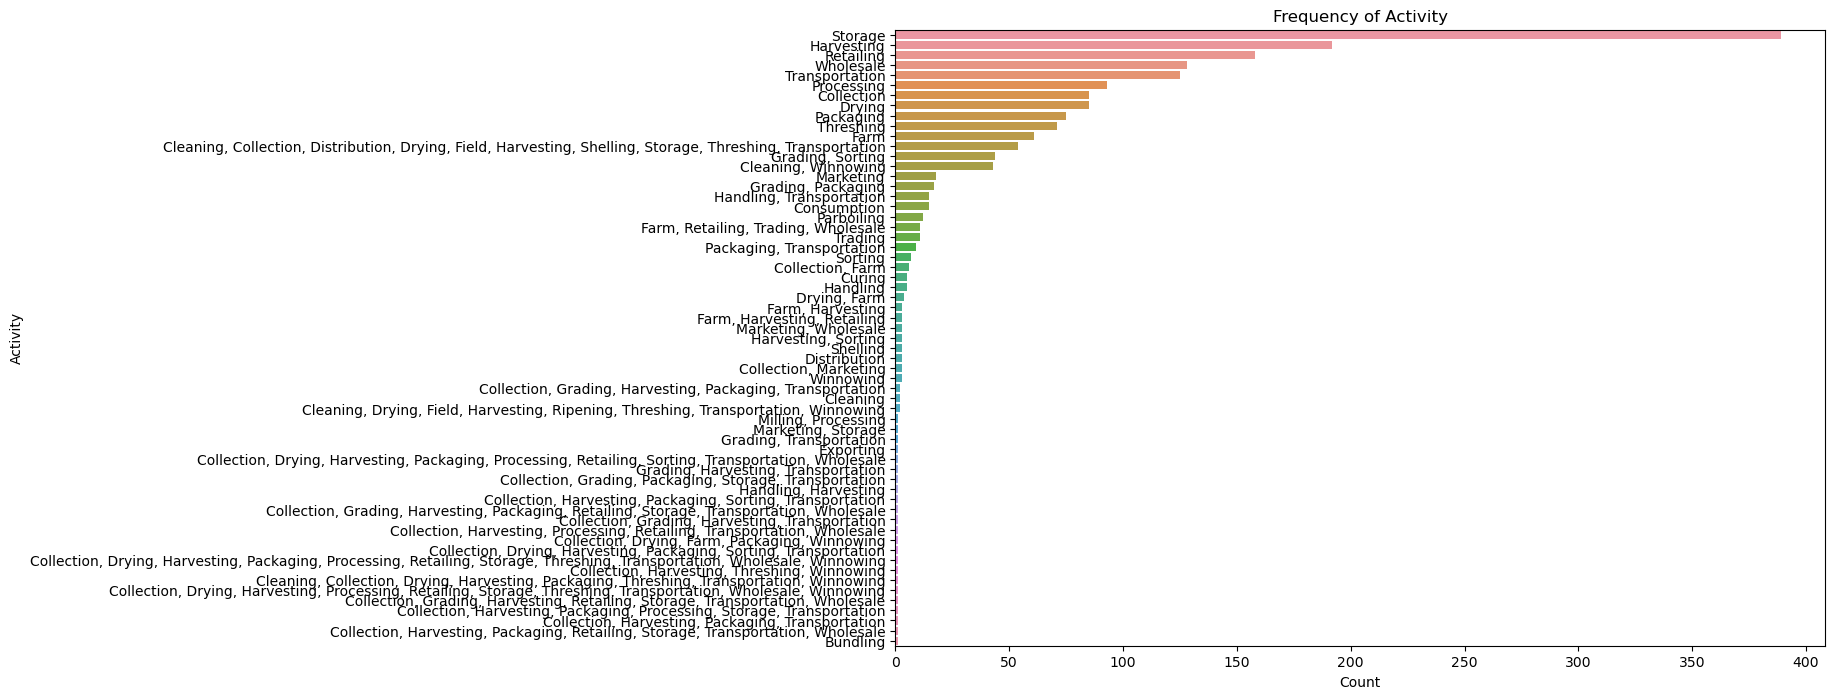

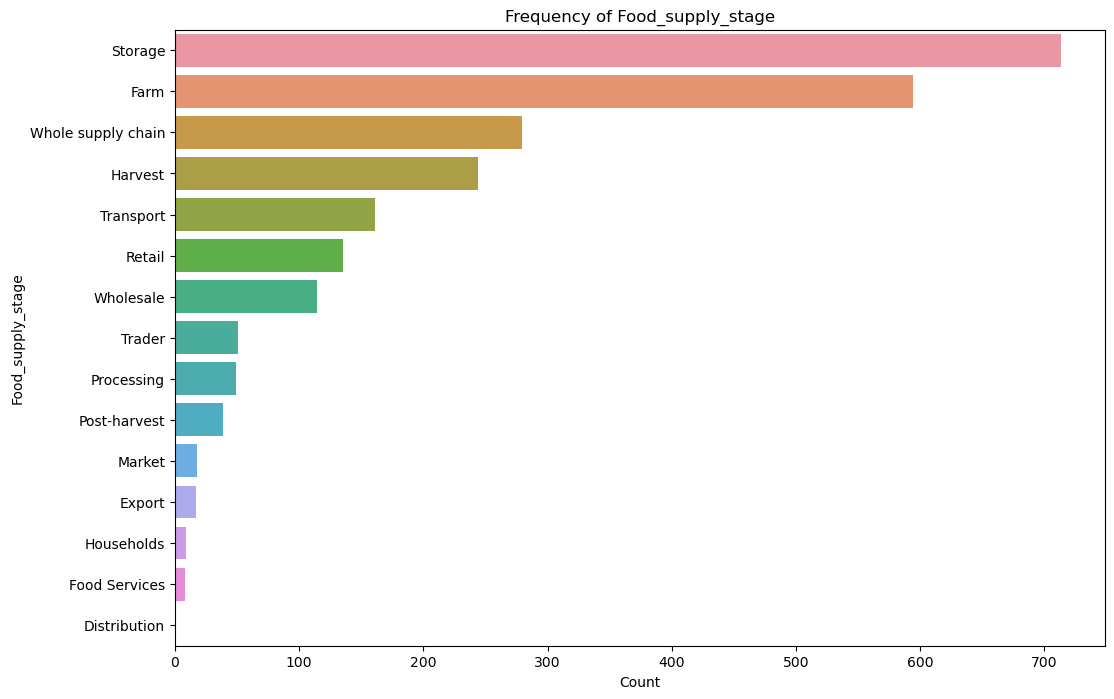

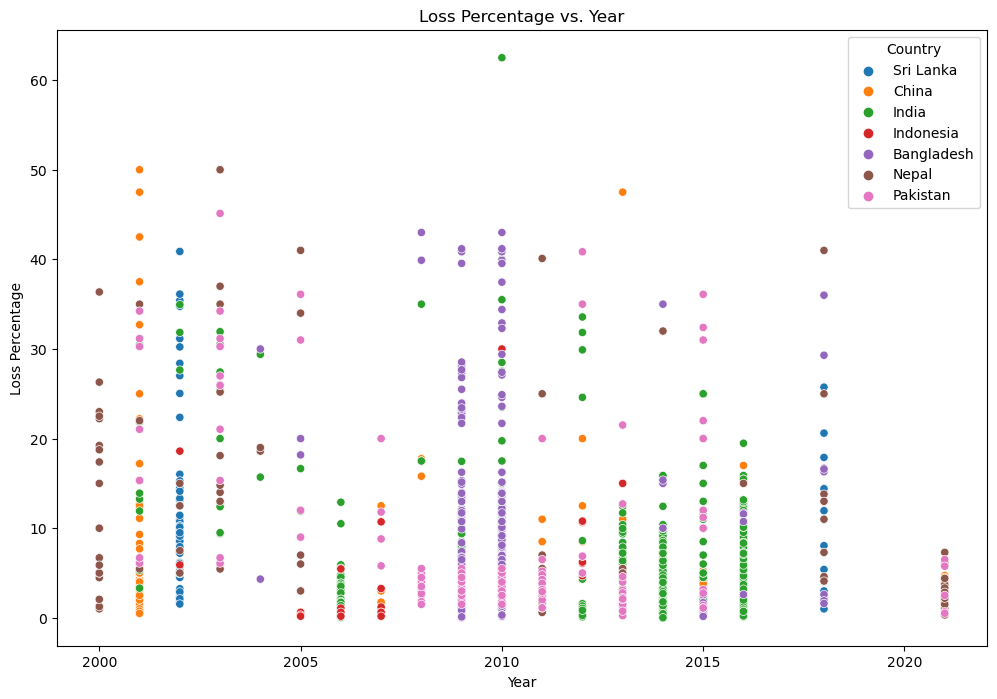

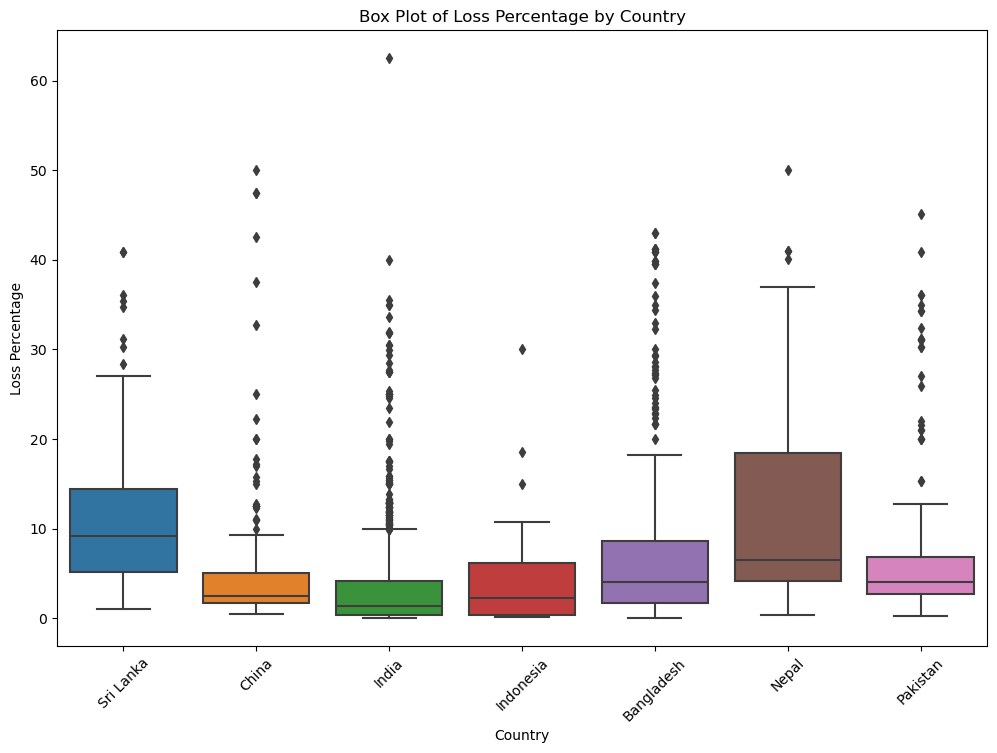

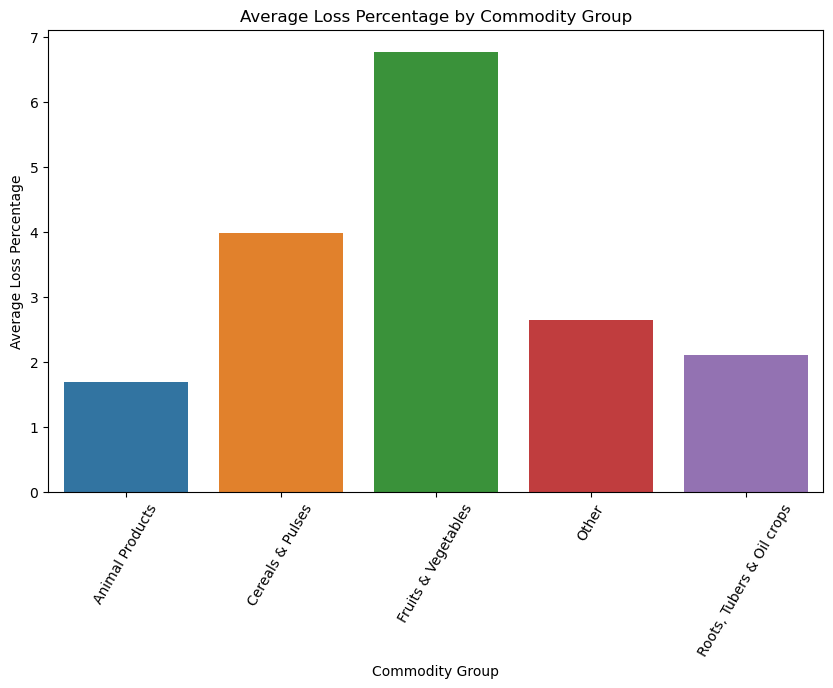

Average Loss Percentage by Commodity Group:
Animal Products: 1.69%
Cereals & Pulses: 3.99%
Fruits & Vegetables: 6.78%
Other: 2.64%
Roots, Tubers & Oil crops: 2.11%


In [10]:
# Pie Chart: Distribution of Countries
plt.figure(figsize=(10, 6))
country_counts = sub_df_cleaned['country'].value_counts()
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Countries')
plt.axis('equal')
plt.show()


# Prepare data
country_counts = sub_df_cleaned['country'].value_counts()
labels = country_counts.index
sizes = country_counts.values

# Bar Chart: Average Loss Percentage by Country
if 'loss_percentage' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    average_loss_percentage = sub_df_cleaned.groupby('country')['loss_percentage'].mean().sort_values()
    ax = sns.barplot(x=average_loss_percentage.values, y=average_loss_percentage.index)
    plt.title('Average Loss Percentage by Country')
    plt.xlabel('Average Loss Percentage')
    plt.ylabel('Country')
    
    # Annotate each bar with its value
    for i, v in enumerate(average_loss_percentage.values):
        ax.text(v + 0.2, i, f'{v:.2f}%', va='center', color='black', fontsize=10, fontweight='bold')
    
    plt.show()
# Calculate average loss percentage by country
average_loss_percentage = sub_df_cleaned.groupby('country')['loss_percentage'].mean().sort_values(ascending=False)

# Print the values
for country, avg_loss in average_loss_percentage.items():
    print(f'{country}: {avg_loss:.2f}%')


# Additional Bar Chart: Frequency of a Categorical Column (e.g., 'activity' or 'food_supply_stage')
categorical_columns = ['activity', 'food_supply_stage']
for col in categorical_columns:
    if col in sub_df_cleaned.columns:
        plt.figure(figsize=(12, 8))
        counts = sub_df_cleaned[col].value_counts()
        sns.barplot(x=counts.values, y=counts.index)
        plt.title(f'Frequency of {col.capitalize()}')
        plt.xlabel('Count')
        plt.ylabel(col.capitalize())
        plt.show()

# Additional Chart: Scatter Plot of Loss Percentage vs. Year
if 'loss_percentage' in sub_df_cleaned.columns and 'year' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='year', y='loss_percentage', data=sub_df_cleaned, hue='country')
    plt.title('Loss Percentage vs. Year')
    plt.xlabel('Year')
    plt.ylabel('Loss Percentage')
    plt.legend(title='Country')
    plt.show()

# Additional Chart: Box Plot of Loss Percentage by Country
if 'loss_percentage' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='country', y='loss_percentage', data=sub_df_cleaned)
    plt.title('Box Plot of Loss Percentage by Country')
    plt.xlabel('Country')
    plt.ylabel('Loss Percentage')
    plt.xticks(rotation=45)
    plt.show()    

# Calculate average loss percentage by commodity group
avg_loss_per_group = sub_df_cleaned.groupby('commodity_group')['loss_percentage'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_loss_per_group.index, y=avg_loss_per_group.values)
plt.title('Average Loss Percentage by Commodity Group')
plt.xlabel('Commodity Group')
plt.ylabel('Average Loss Percentage')
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xticks(rotation=60)  # Increase rotation angle (e.g., 60 degrees)

plt.show()
# Print the average loss percentage values
print("Average Loss Percentage by Commodity Group:")
for group, avg_loss in avg_loss_per_group.items():
    print(f"{group}: {avg_loss:.2f}%")


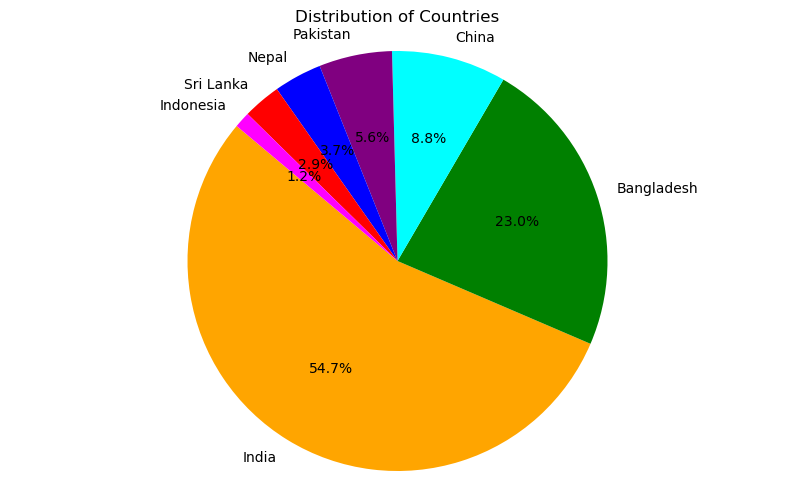

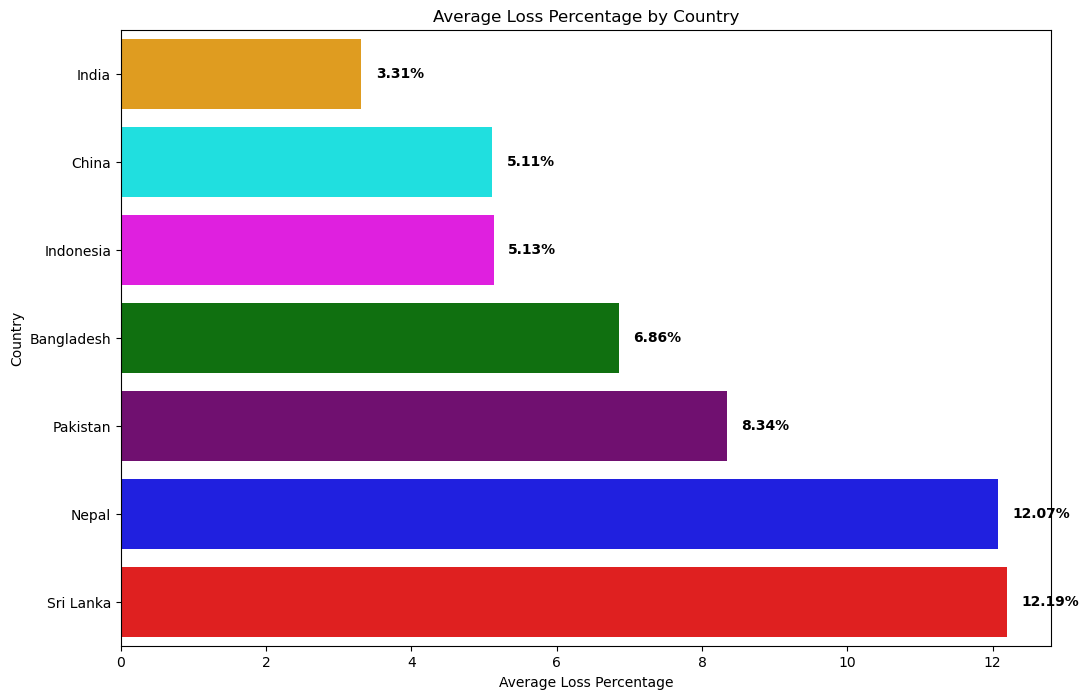

India: 3.31%
China: 5.11%
Indonesia: 5.13%
Bangladesh: 6.86%
Pakistan: 8.34%
Nepal: 12.07%
Sri Lanka: 12.19%


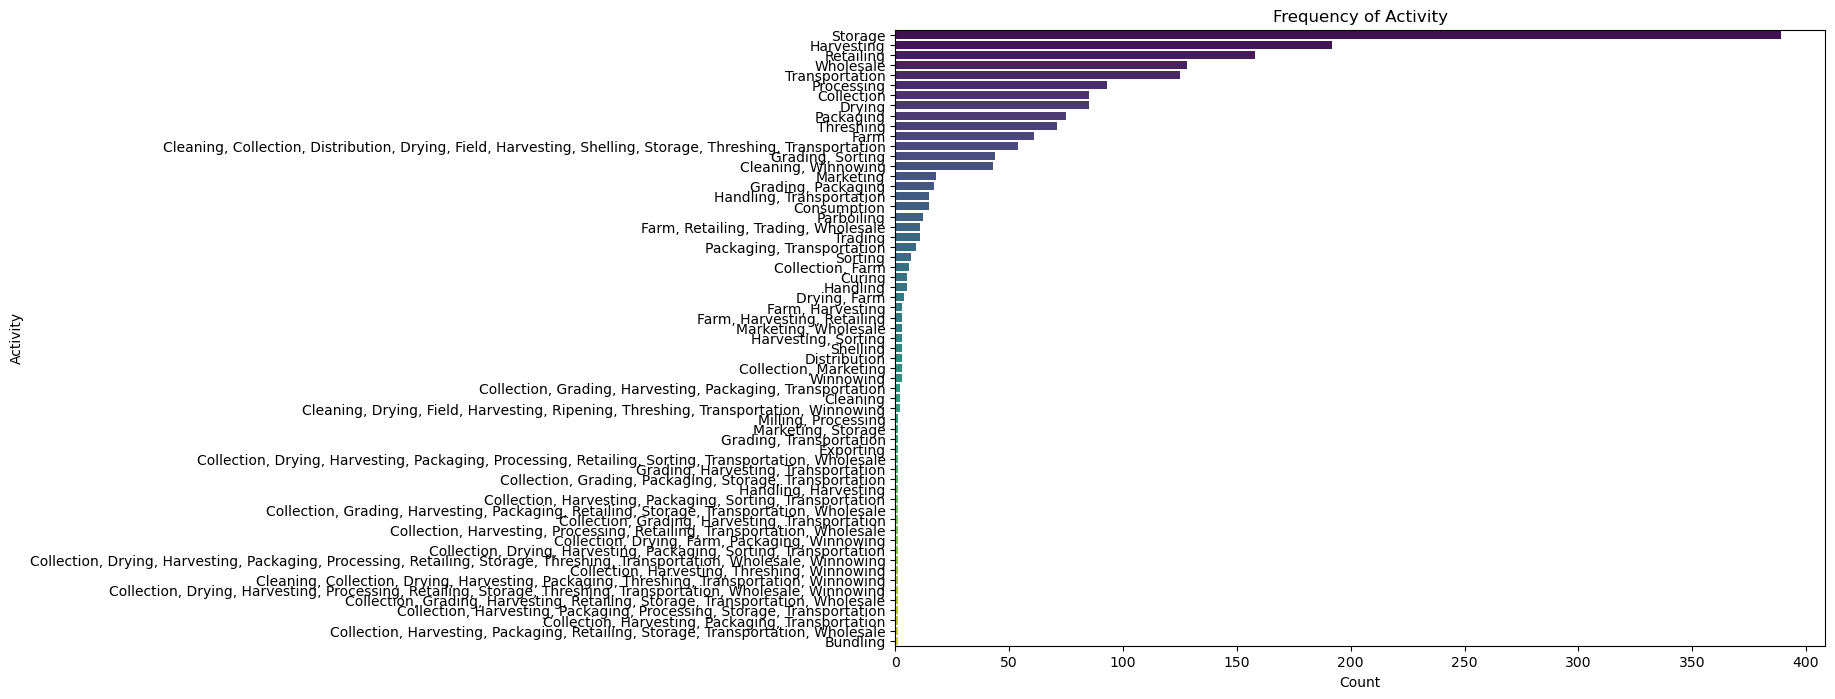

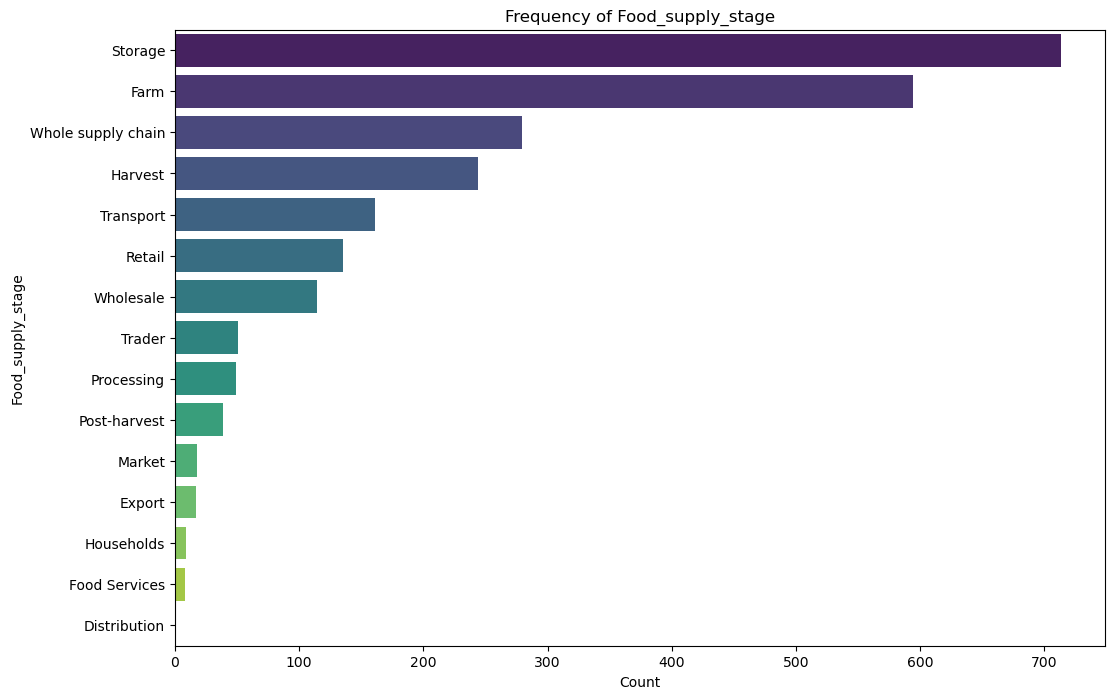

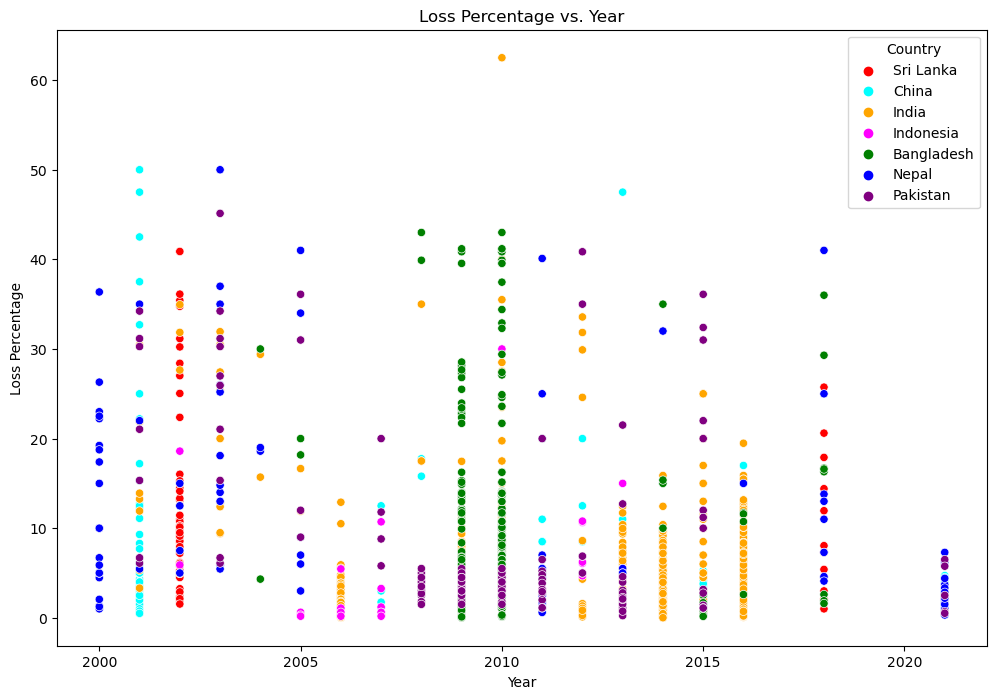

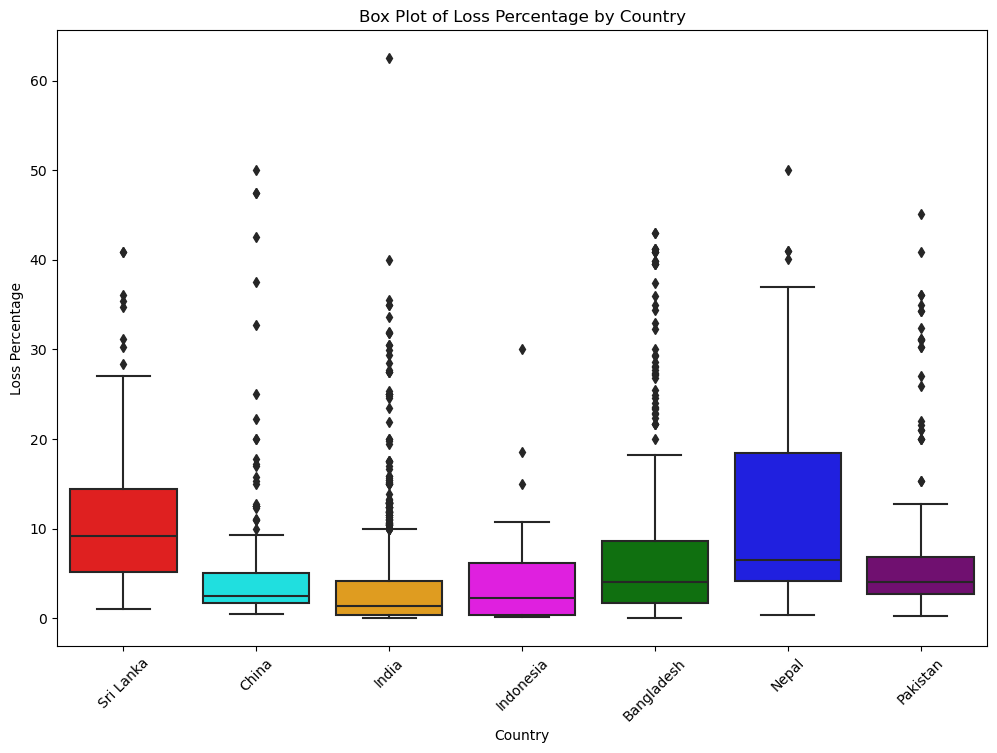

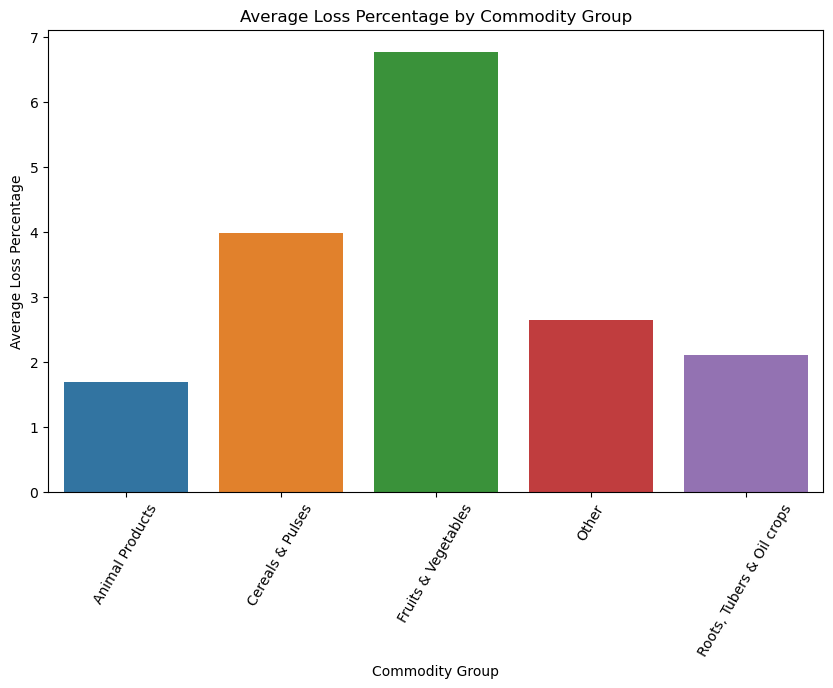

Average Loss Percentage by Commodity Group:
Animal Products: 1.69%
Cereals & Pulses: 3.99%
Fruits & Vegetables: 6.78%
Other: 2.64%
Roots, Tubers & Oil crops: 2.11%


In [12]:
# Example DataFrame (replace this with your actual DataFrame)
# sub_df_cleaned = pd.read_csv('your_data.csv')

# Define a color palette for countries
country_palette = {
    'Bangladesh': 'green',
    'Nepal': 'blue',
    'Sri Lanka': 'red',
    'Pakistan': 'purple',
    'India': 'orange',
    'China': 'cyan',
    'Indonesia': 'magenta'
}

# Pie Chart: Distribution of Countries
plt.figure(figsize=(10, 6))
country_counts = sub_df_cleaned['country'].value_counts()
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', startangle=140,
        colors=[country_palette[country] for country in country_counts.index])
plt.title('Distribution of Countries')
plt.axis('equal')
plt.show()

# Prepare data
country_counts = sub_df_cleaned['country'].value_counts()
labels = country_counts.index
sizes = country_counts.values

# Bar Chart: Average Loss Percentage by Country
if 'loss_percentage' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    average_loss_percentage = sub_df_cleaned.groupby('country')['loss_percentage'].mean().sort_values()
    ax = sns.barplot(x=average_loss_percentage.values, y=average_loss_percentage.index,
                     palette=[country_palette[country] for country in average_loss_percentage.index])
    plt.title('Average Loss Percentage by Country')
    plt.xlabel('Average Loss Percentage')
    plt.ylabel('Country')
    
    # Annotate each bar with its value
    for i, v in enumerate(average_loss_percentage.values):
        ax.text(v + 0.2, i, f'{v:.2f}%', va='center', color='black', fontsize=10, fontweight='bold')
    
    plt.show()

# Print the values
for country, avg_loss in average_loss_percentage.items():
    print(f'{country}: {avg_loss:.2f}%')

# Additional Bar Chart: Frequency of a Categorical Column (e.g., 'activity' or 'food_supply_stage')
categorical_columns = ['activity', 'food_supply_stage']
for col in categorical_columns:
    if col in sub_df_cleaned.columns:
        plt.figure(figsize=(12, 8))
        counts = sub_df_cleaned[col].value_counts()
        sns.barplot(x=counts.values, y=counts.index, palette=sns.color_palette("viridis", len(counts)))
        plt.title(f'Frequency of {col.capitalize()}')
        plt.xlabel('Count')
        plt.ylabel(col.capitalize())
        plt.show()

# Additional Chart: Scatter Plot of Loss Percentage vs. Year
if 'loss_percentage' in sub_df_cleaned.columns and 'year' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='year', y='loss_percentage', data=sub_df_cleaned, hue='country', palette=country_palette)
    plt.title('Loss Percentage vs. Year')
    plt.xlabel('Year')
    plt.ylabel('Loss Percentage')
    plt.legend(title='Country')
    plt.show()

# Additional Chart: Box Plot of Loss Percentage by Country
if 'loss_percentage' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='country', y='loss_percentage', data=sub_df_cleaned, palette=country_palette)
    plt.title('Box Plot of Loss Percentage by Country')
    plt.xlabel('Country')
    plt.ylabel('Loss Percentage')
    plt.xticks(rotation=45)
    plt.show()    

# Calculate average loss percentage by commodity group
avg_loss_per_group = sub_df_cleaned.groupby('commodity_group')['loss_percentage'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_loss_per_group.index, y=avg_loss_per_group.values)
plt.title('Average Loss Percentage by Commodity Group')
plt.xlabel('Commodity Group')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=60)  # Increase rotation angle (e.g., 60 degrees)
plt.show()

# Print the average loss percentage values
print("Average Loss Percentage by Commodity Group:")
for group, avg_loss in avg_loss_per_group.items():
    print(f"{group}: {avg_loss:.2f}%")


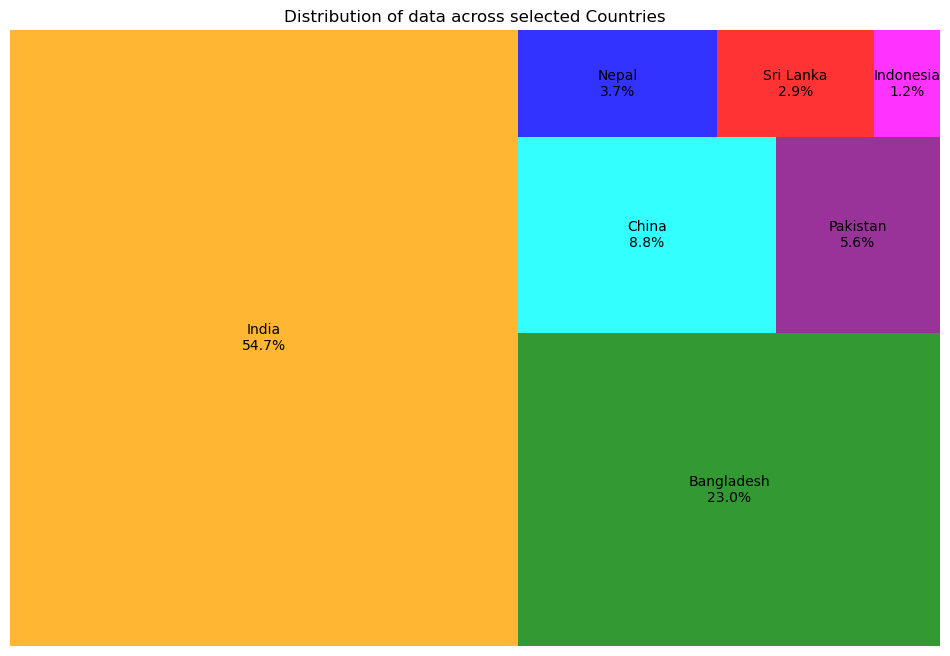

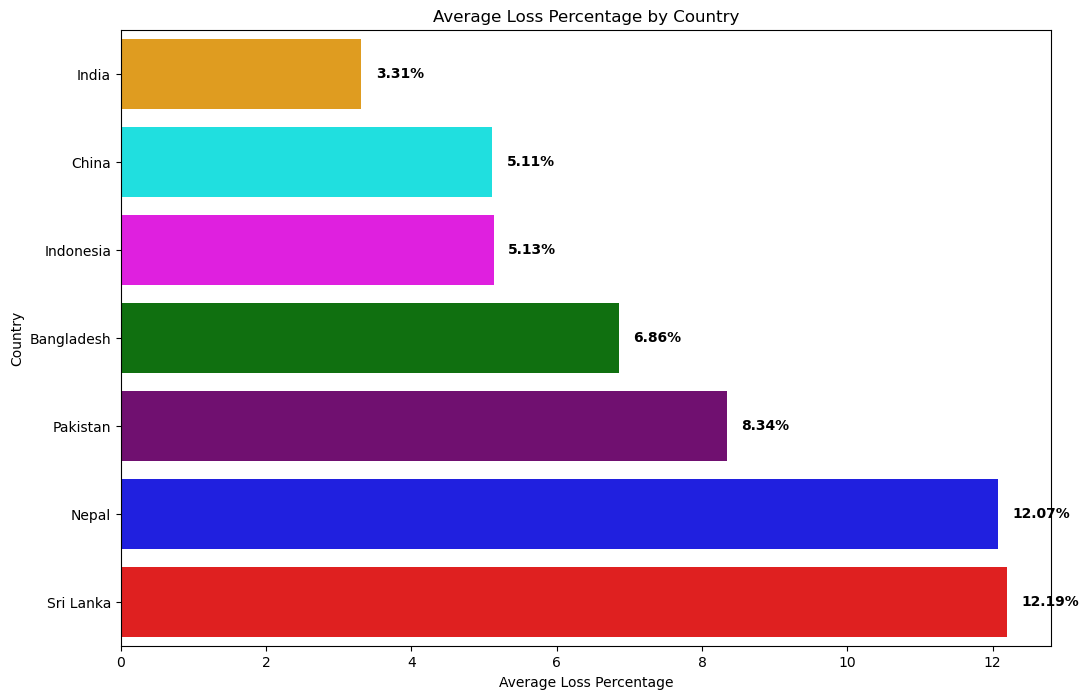

India: 3.31%
China: 5.11%
Indonesia: 5.13%
Bangladesh: 6.86%
Pakistan: 8.34%
Nepal: 12.07%
Sri Lanka: 12.19%


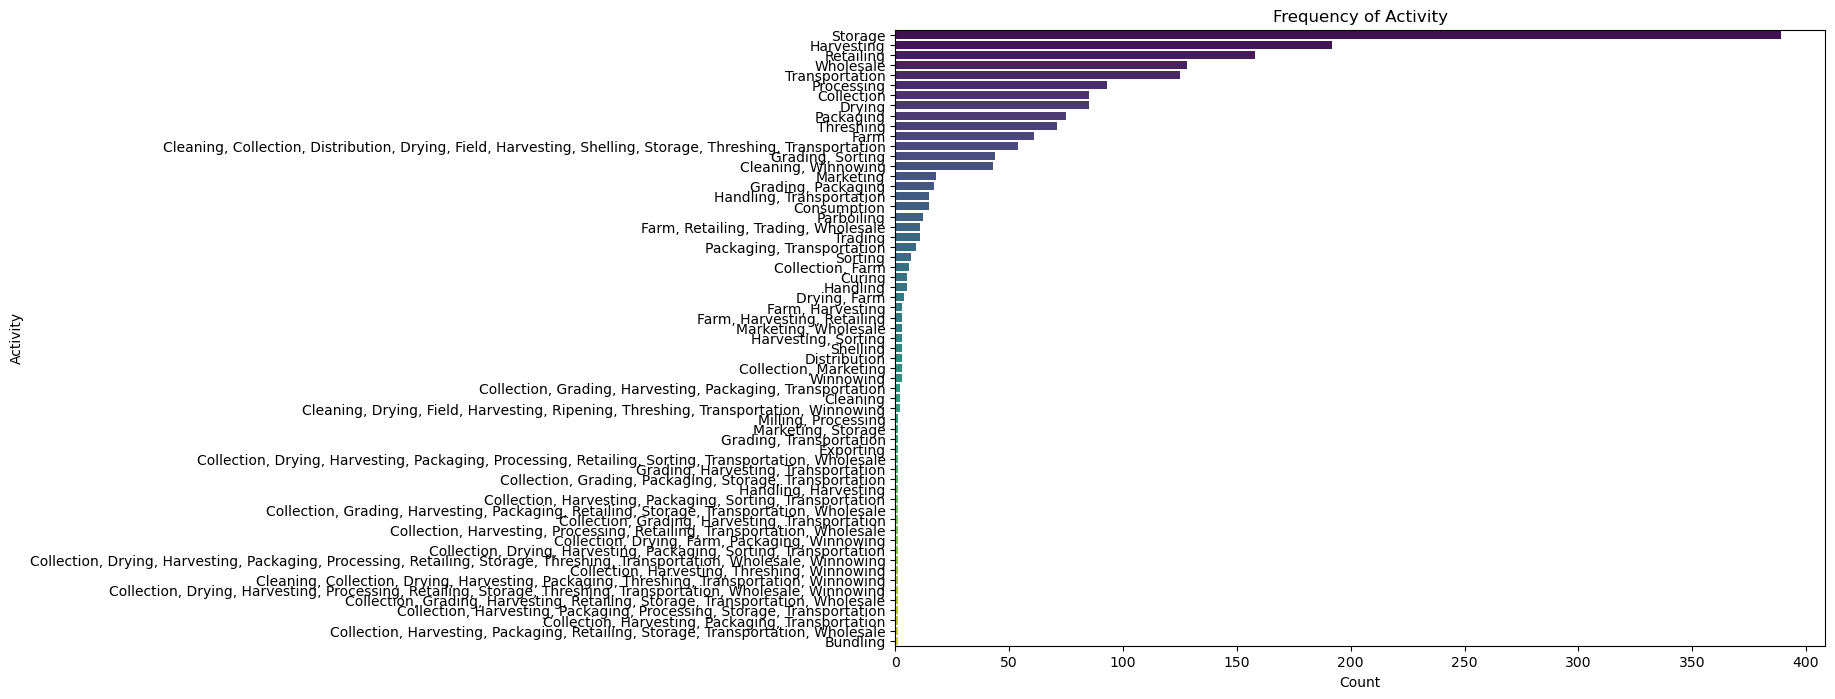

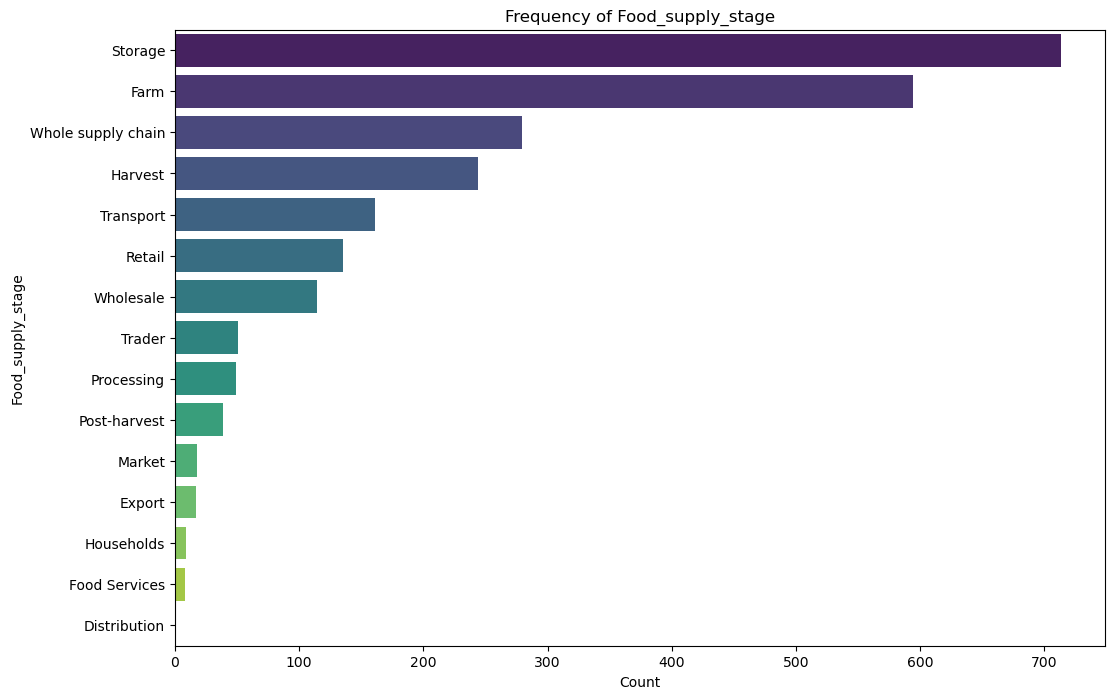

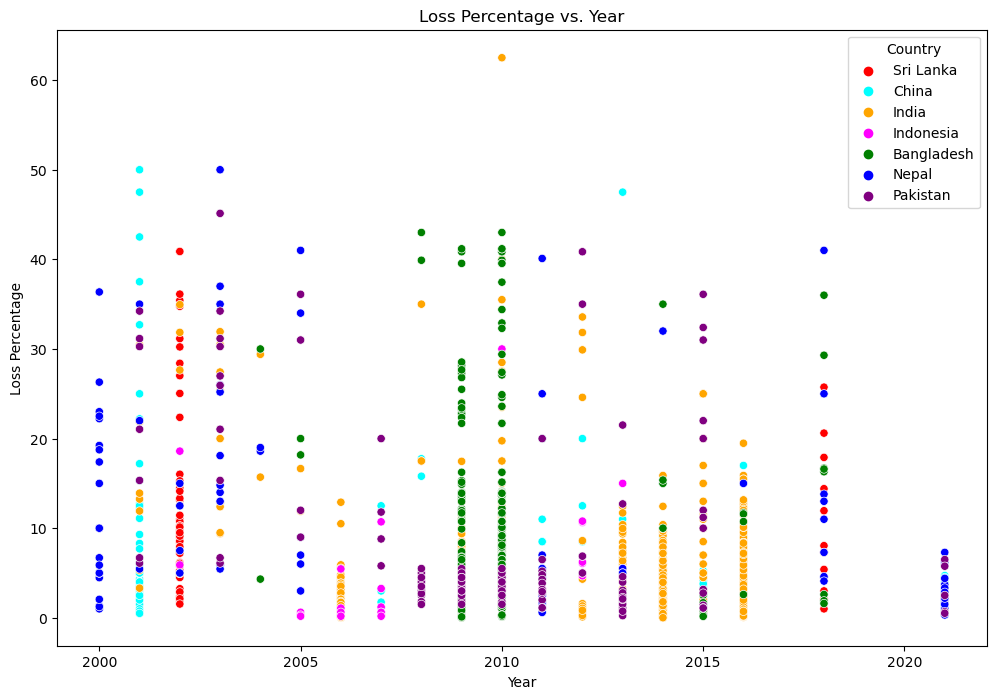

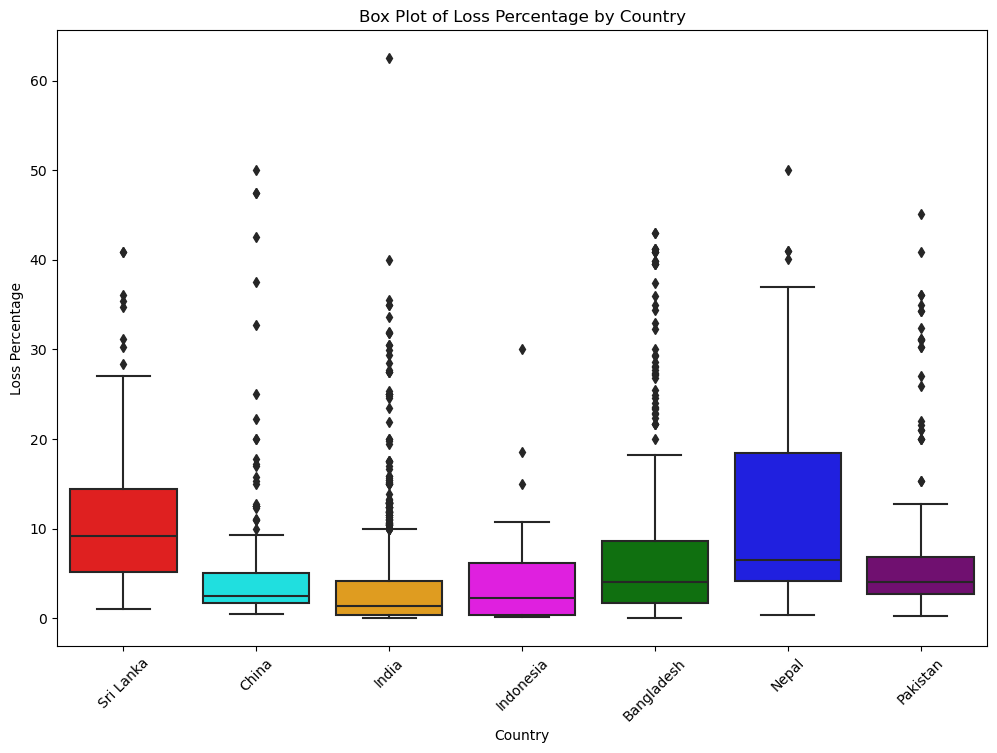

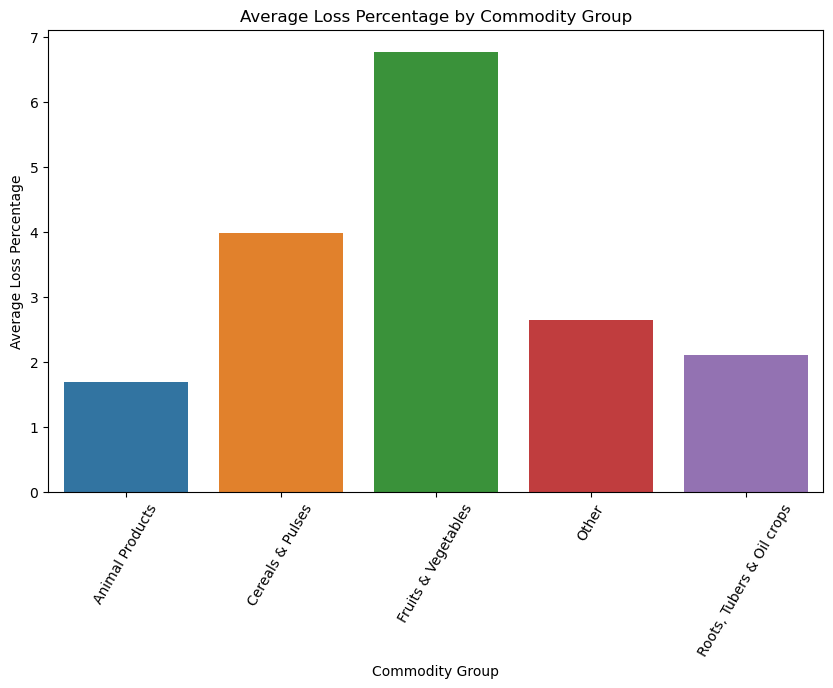

Average Loss Percentage by Commodity Group:
Animal Products: 1.69%
Cereals & Pulses: 3.99%
Fruits & Vegetables: 6.78%
Other: 2.64%
Roots, Tubers & Oil crops: 2.11%


In [13]:
# Prepare data for the treemap
country_counts = sub_df_cleaned['country'].value_counts()
labels = country_counts.index
sizes = country_counts.values

# Calculate percentages
total = sizes.sum()
labels_with_percentage = [f'{label}\n{size/total:.1%}' for label, size in zip(labels, sizes)]

# Create a treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels_with_percentage, color=[country_palette[country] for country in labels], alpha=0.8)
plt.title('Distribution of data across selected Countries')
plt.axis('off')
plt.show()
# Prepare data
country_counts = sub_df_cleaned['country'].value_counts()
labels = country_counts.index
sizes = country_counts.values

# Bar Chart: Average Loss Percentage by Country
if 'loss_percentage' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    average_loss_percentage = sub_df_cleaned.groupby('country')['loss_percentage'].mean().sort_values()
    ax = sns.barplot(x=average_loss_percentage.values, y=average_loss_percentage.index,
                     palette=[country_palette[country] for country in average_loss_percentage.index])
    plt.title('Average Loss Percentage by Country')
    plt.xlabel('Average Loss Percentage')
    plt.ylabel('Country')
    
    # Annotate each bar with its value
    for i, v in enumerate(average_loss_percentage.values):
        ax.text(v + 0.2, i, f'{v:.2f}%', va='center', color='black', fontsize=10, fontweight='bold')
    
    plt.show()

# Print the values
for country, avg_loss in average_loss_percentage.items():
    print(f'{country}: {avg_loss:.2f}%')

# Additional Bar Chart: Frequency of a Categorical Column (e.g., 'activity' or 'food_supply_stage')
categorical_columns = ['activity', 'food_supply_stage']
for col in categorical_columns:
    if col in sub_df_cleaned.columns:
        plt.figure(figsize=(12, 8))
        counts = sub_df_cleaned[col].value_counts()
        sns.barplot(x=counts.values, y=counts.index, palette=sns.color_palette("viridis", len(counts)))
        plt.title(f'Frequency of {col.capitalize()}')
        plt.xlabel('Count')
        plt.ylabel(col.capitalize())
        plt.show()

# Additional Chart: Scatter Plot of Loss Percentage vs. Year
if 'loss_percentage' in sub_df_cleaned.columns and 'year' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='year', y='loss_percentage', data=sub_df_cleaned, hue='country', palette=country_palette)
    plt.title('Loss Percentage vs. Year')
    plt.xlabel('Year')
    plt.ylabel('Loss Percentage')
    plt.legend(title='Country')
    plt.show()

# Additional Chart: Box Plot of Loss Percentage by Country
if 'loss_percentage' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='country', y='loss_percentage', data=sub_df_cleaned, palette=country_palette)
    plt.title('Box Plot of Loss Percentage by Country')
    plt.xlabel('Country')
    plt.ylabel('Loss Percentage')
    plt.xticks(rotation=45)
    plt.show()    

# Calculate average loss percentage by commodity group
avg_loss_per_group = sub_df_cleaned.groupby('commodity_group')['loss_percentage'].mean()

# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_loss_per_group.index, y=avg_loss_per_group.values)
plt.title('Average Loss Percentage by Commodity Group')
plt.xlabel('Commodity Group')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=60)  # Increase rotation angle (e.g., 60 degrees)
plt.show()

# Print the average loss percentage values
print("Average Loss Percentage by Commodity Group:")
for group, avg_loss in avg_loss_per_group.items():
    print(f"{group}: {avg_loss:.2f}%")




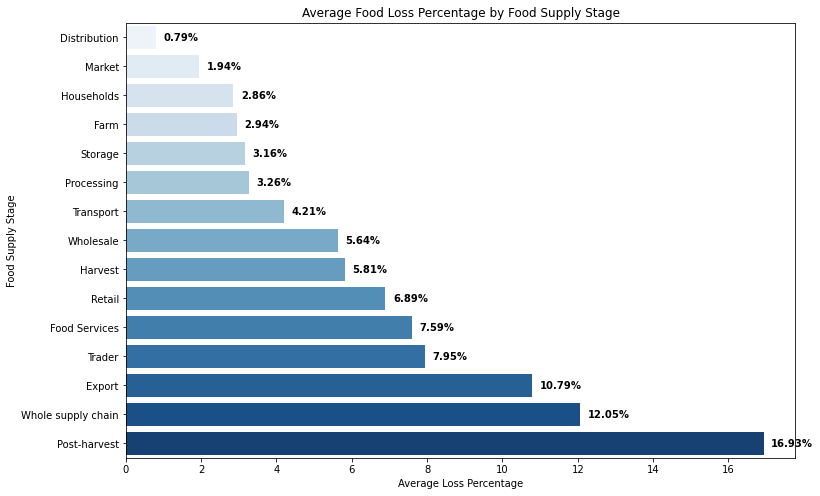

Distribution: 0.79%
Market: 1.94%
Households: 2.86%
Farm: 2.94%
Storage: 3.16%
Processing: 3.26%
Transport: 4.21%
Wholesale: 5.64%
Harvest: 5.81%
Retail: 6.89%
Food Services: 7.59%
Trader: 7.95%
Export: 10.79%
Whole supply chain: 12.05%
Post-harvest: 16.93%


In [40]:
# Bar Chart: Average Loss Percentage by Food Supply Stage
if 'loss_percentage' in sub_df_cleaned.columns and 'food_supply_stage' in sub_df_cleaned.columns:
    plt.figure(figsize=(12, 8))
    avg_loss_by_stage = sub_df_cleaned.groupby('food_supply_stage')['loss_percentage'].mean().sort_values()
    ax = sns.barplot(x=avg_loss_by_stage.values, y=avg_loss_by_stage.index, palette='Blues')
    plt.title('Average Food Loss Percentage by Food Supply Stage')
    plt.xlabel('Average Loss Percentage')
    plt.ylabel('Food Supply Stage')
    
    # Annotate each bar with its value
    for i, v in enumerate(avg_loss_by_stage.values):
        ax.text(v + 0.2, i, f'{v:.2f}%', va='center', color='black', fontsize=10, fontweight='bold')
    
    plt.savefig('bar_chart_average_loss_percentage_by_food_supply_stage.png')
    plt.show()

    # Print the average loss percentage for each food supply stage
for stage, avg_loss in avg_loss_by_stage.items():
    print(f'{stage}: {avg_loss:.2f}%')


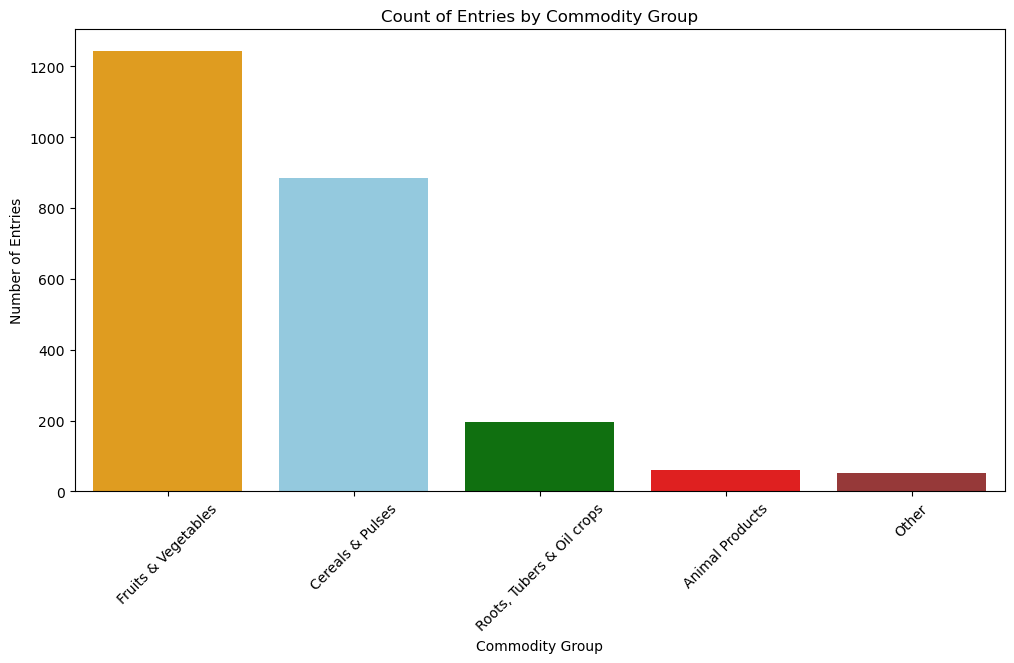

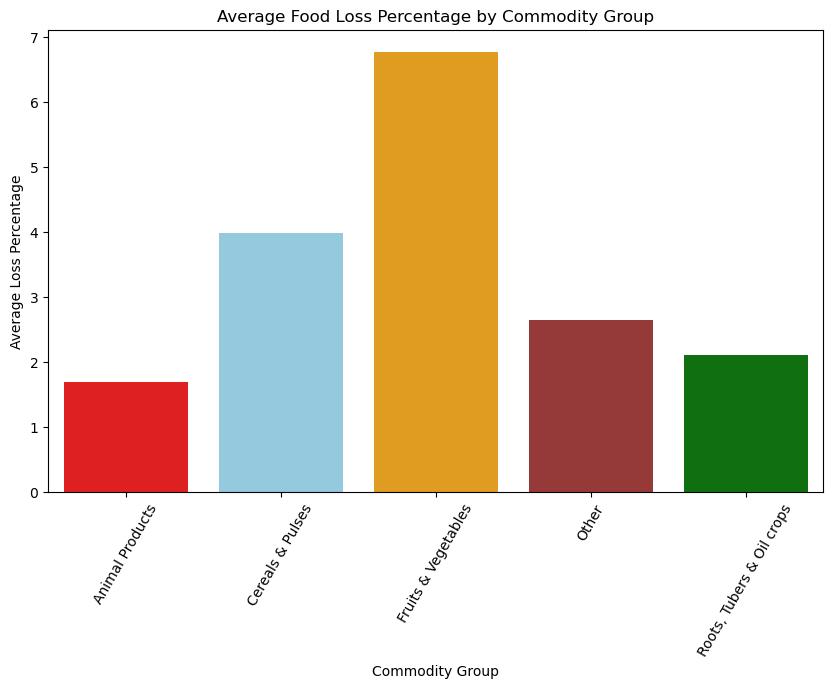

Animal Products: 1.69%
Cereals & Pulses: 3.99%
Fruits & Vegetables: 6.78%
Other: 2.64%
Roots, Tubers & Oil crops: 2.11%


In [14]:
# Define a color palette with updated commodity groups
commodity_palette = {
    'Cereals & Pulses': 'skyblue',
    'Fruits & Vegetables': 'orange',
    'Roots, Tubers & Oil crops': 'green',
    'Animal Products': 'red',
    'Other': 'brown'
}

# Count of entries for each commodity group
plt.figure(figsize=(12, 6))
commodity_counts = sub_df_cleaned['commodity_group'].value_counts()
sns.barplot(x=commodity_counts.index, y=commodity_counts.values, palette=commodity_palette)
plt.title('Count of Entries by Commodity Group')
plt.xlabel('Commodity Group')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)
plt.show()

# Calculate average loss percentage by commodity group
avg_loss_per_group = sub_df_cleaned.groupby('commodity_group')['loss_percentage'].mean()

# Create a bar chart with the color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_loss_per_group.index, y=avg_loss_per_group.values, palette=commodity_palette)
plt.title('Average Food Loss Percentage by Commodity Group')
plt.xlabel('Commodity Group')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=60)  # Increase rotation angle for better readability
plt.show()
# Print average loss percentage for each commodity group
for commodity, avg_loss in avg_loss_per_group.items():
    print(f'{commodity}: {avg_loss:.2f}%')


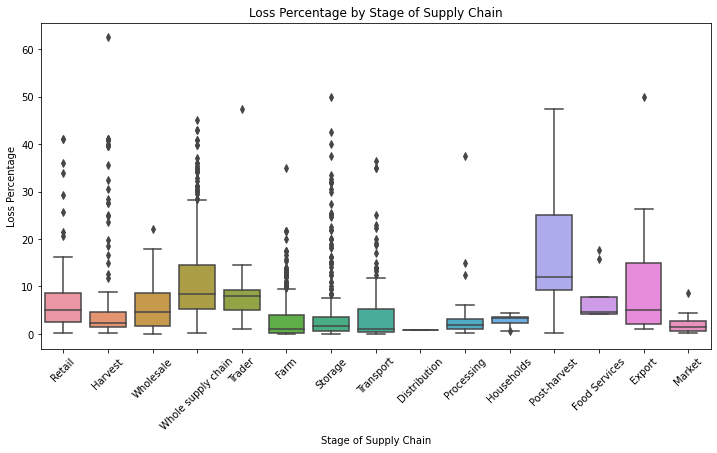

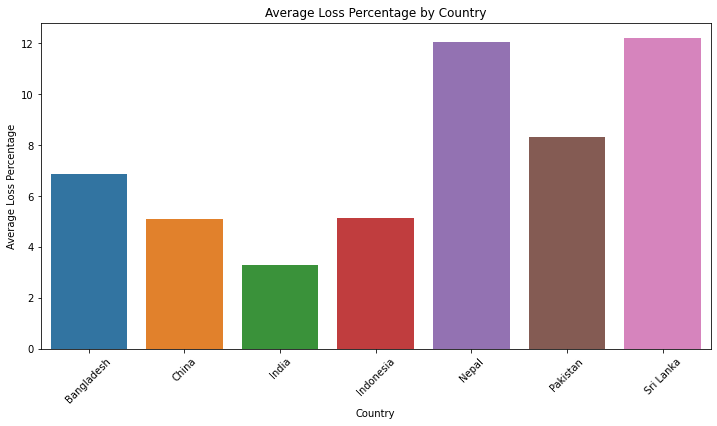

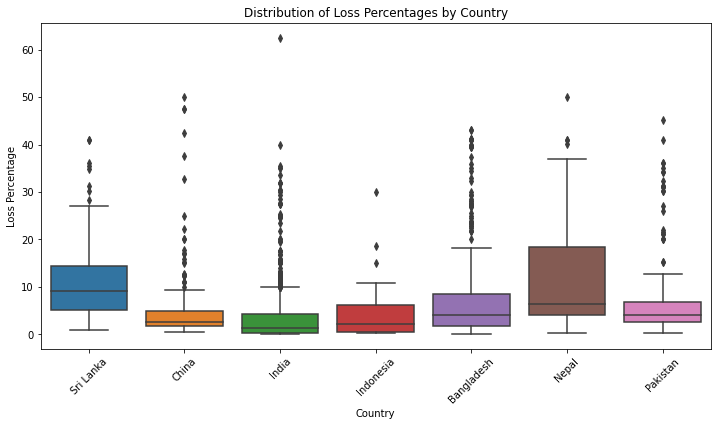

In [42]:
# Box plot of loss percentages by stage
plt.figure(figsize=(12, 6))
sns.boxplot(x='food_supply_stage', y='loss_percentage', data=sub_df_cleaned)
plt.title('Loss Percentage by Stage of Supply Chain')
plt.xlabel('Stage of Supply Chain')
plt.ylabel('Loss Percentage')
plt.xticks(rotation=45)
plt.show()
# Average loss percentage by country
avg_loss_by_country = sub_df_cleaned.groupby('country')['loss_percentage'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_loss_by_country.index, y=avg_loss_by_country.values)
plt.title('Average Loss Percentage by Country')
plt.xlabel('Country')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=45)
plt.show()

# Box plot of loss percentages by country
plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='loss_percentage', data=sub_df_cleaned)
plt.title('Distribution of Loss Percentages by Country')
plt.xlabel('Country')
plt.ylabel('Loss Percentage')
plt.xticks(rotation=45)
plt.show()



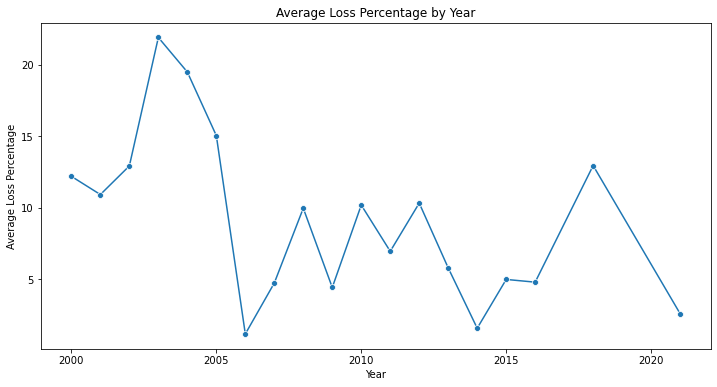

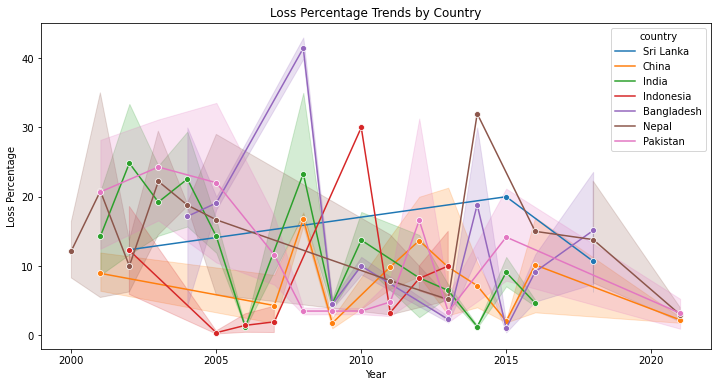

In [43]:
# Average loss percentage per year
avg_loss_by_year = sub_df_cleaned.groupby('year')['loss_percentage'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_loss_by_year.index, y=avg_loss_by_year.values, marker='o')
plt.title('Average Loss Percentage by Year')
plt.xlabel('Year')
plt.ylabel('Average Loss Percentage')
plt.show()

# Line graph of loss percentage trends by country
plt.figure(figsize=(12, 6))
sns.lineplot(data=sub_df_cleaned, x='year', y='loss_percentage', hue='country', marker='o')
plt.title('Loss Percentage Trends by Country')
plt.xlabel('Year')
plt.ylabel('Loss Percentage')
plt.show()


C:\Users\Nutzer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


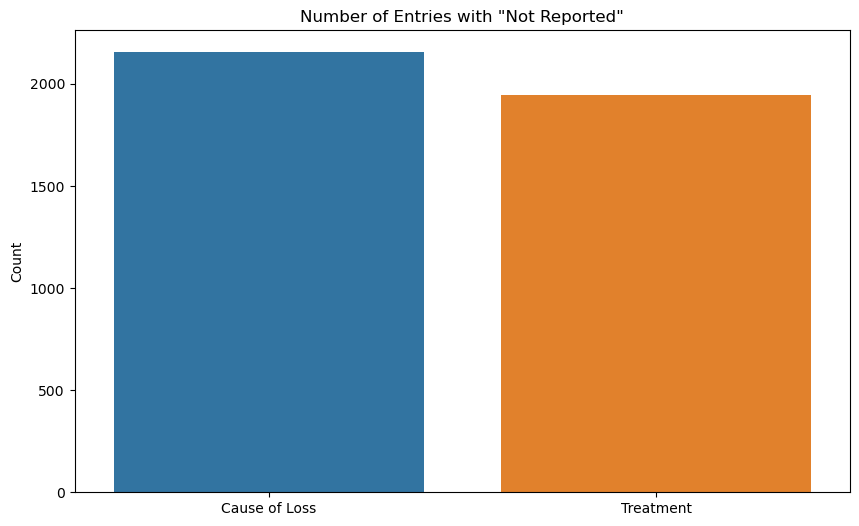

Number of 'Not Reported' entries in cause_of_loss: 2155
Number of 'Not Reported' entries in treatment: 1945


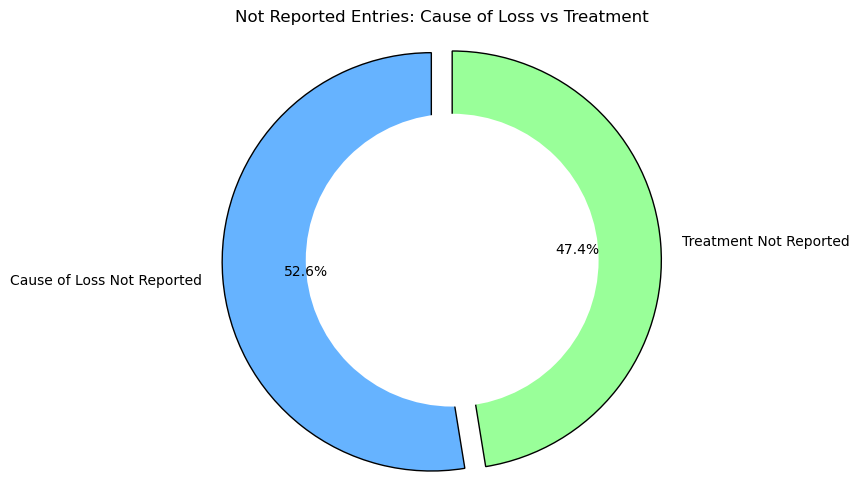

In [15]:
# Count occurrences of 'Not Reported' in 'cause_of_loss' column
cause_of_loss_counts = sub_df_cleaned['cause_of_loss'].value_counts()
cause_of_loss_not_reported = cause_of_loss_counts.get('Not Reported', 0)

# Count occurrences of 'Not Reported' in 'treatment' column
treatment_counts = sub_df_cleaned['treatment'].value_counts()
treatment_not_reported = treatment_counts.get('Not Reported', 0)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=['Cause of Loss', 'Treatment'], y=[cause_of_loss_not_reported, treatment_not_reported])
plt.title('Number of Entries with "Not Reported"')
plt.ylabel('Count')
plt.show()
print(f"Number of 'Not Reported' entries in cause_of_loss: {cause_of_loss_not_reported}")
print(f"Number of 'Not Reported' entries in treatment: {treatment_not_reported}")


# Assuming sub_df_cleaned is your DataFrame
# Count occurrences of 'Not Reported' in 'cause_of_loss' column
cause_of_loss_not_reported = sub_df_cleaned[sub_df_cleaned['cause_of_loss'] == 'Not Reported'].shape[0]

# Count occurrences of 'Not Reported' in 'treatment' column
treatment_not_reported = sub_df_cleaned[sub_df_cleaned['treatment'] == 'Not Reported'].shape[0]

# Prepare data for the donut chart
labels = ['Cause of Loss Not Reported', 'Treatment Not Reported']
sizes = [cause_of_loss_not_reported, treatment_not_reported]
colors = ['#66b3ff', '#99ff99']
explode = (0.1, 0)  # explode 1st slice (Cause of Loss) to create donut effect

# Plotting the donut chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding a circle at the center to turn the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Not Reported Entries: Cause of Loss vs Treatment')
plt.show()


In [45]:
# Filter data for 'Fruits & Vegetables' commodity group and exclude 'Not Reported' causes
filtered_df = sub_df_cleaned[(sub_df_cleaned['commodity_group'] == 'Fruits & Vegetables') & 
                             (sub_df_cleaned['cause_of_loss'] != 'Not Reported')]

# Count occurrences of each cause of loss
cause_of_loss_counts = filtered_df['cause_of_loss'].value_counts()

# Print the most common cause(s) of loss
most_common_cause = cause_of_loss_counts.idxmax()
most_common_count = cause_of_loss_counts.max()

print(f"The most common cause of loss in Fruits & Vegetables (excluding 'Not Reported') is '{most_common_cause}' with {most_common_count} occurrences.")




The most common cause of loss in Fruits & Vegetables (excluding 'Not Reported') is 'Physical Losses' with 22 occurrences.


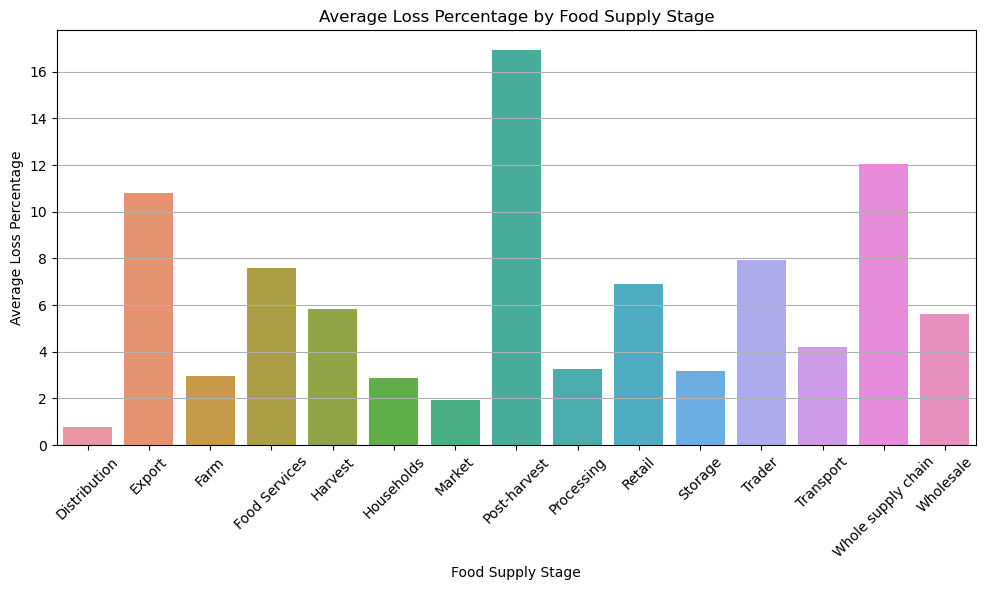

<Figure size 1200x800 with 0 Axes>

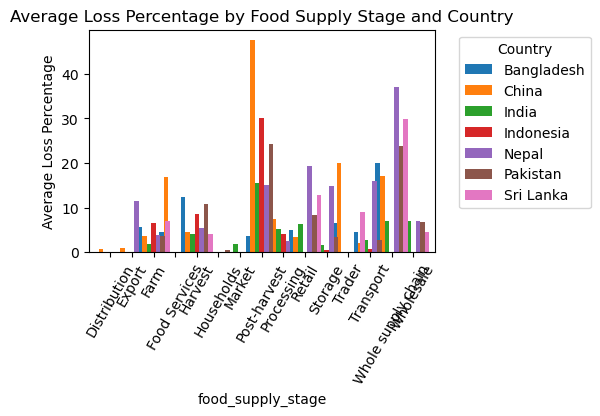

Country with the highest average loss percentage:
country                     China
food_supply_stage    Post-harvest
loss_percentage              47.5
Name: 18, dtype: object
Maximum Average Loss Percentage by Food Supply Stage:
food_supply_stage
Distribution           0.790000
Export                11.399375
Farm                   7.049091
Food Services         16.775000
Harvest               12.395139
Households             3.536667
Market                 1.941667
Post-harvest          47.500000
Processing             7.436667
Retail                19.425000
Storage               14.880500
Trader                19.933333
Transport             15.916250
Whole supply chain    37.000000
Wholesale              7.600000
Name: loss_percentage, dtype: float64
Highest Average Loss Percentage by Food Supply Stage and Country:
       country   food_supply_stage  loss_percentage
12       China        Distribution         0.790000
42       Nepal              Export        11.399375
61   Sri Lan

In [16]:
data_selected = sub_df_cleaned[['loss_percentage', 'food_supply_stage']]

# Step 2: Group by 'food_supply_stage' and calculate mean 'loss_percentage'
average_loss_percentage = data_selected.groupby('food_supply_stage')['loss_percentage'].mean().reset_index()

# Step 3: Visualization (optional)
plt.figure(figsize=(10, 6))
sns.barplot(x='food_supply_stage', y='loss_percentage', data=average_loss_percentage)
plt.title('Average Loss Percentage by Food Supply Stage')
plt.xlabel('Food Supply Stage')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Group by country and supply chain stage and calculate the mean loss percentage
avg_loss_per_country_stage = sub_df_cleaned.groupby(['country', 'food_supply_stage'])['loss_percentage'].mean().reset_index()

# Pivot the DataFrame for better plotting
pivot_stage_df = avg_loss_per_country_stage.pivot(index='food_supply_stage', columns='country', values='loss_percentage')

# Plotting the results
plt.figure(figsize=(12, 8))
pivot_stage_df.plot(kind='bar', width=1.5)
plt.title('Average Loss Percentage by Food Supply Stage and Country')
plt.xlabel('food_supply_stage')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=60)  # Adjust rotation angle if needed
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.tight_layout(pad=3)  # Adjust layout to make room for labels
plt.show()



# Group by country and supply chain stage and calculate the mean loss percentage
avg_loss_per_country_stage = sub_df_cleaned.groupby(['country', 'food_supply_stage'])['loss_percentage'].mean().reset_index()

# Find the highest average loss percentage
highest_loss = avg_loss_per_country_stage.loc[avg_loss_per_country_stage['loss_percentage'].idxmax()]

print("Country with the highest average loss percentage:")
print(highest_loss)

# Group by country and supply chain stage and calculate the mean loss percentage
avg_loss_per_country_stage = sub_df_cleaned.groupby(['country', 'food_supply_stage'])['loss_percentage'].mean().reset_index()

# Find the maximum loss percentage in each food supply stage
max_loss_per_stage = avg_loss_per_country_stage.groupby('food_supply_stage')['loss_percentage'].max()

# Print the maximum values
print("Maximum Average Loss Percentage by Food Supply Stage:")
print(max_loss_per_stage)

# Group by country and supply chain stage and calculate the mean loss percentage
avg_loss_per_country_stage = sub_df_cleaned.groupby(['country', 'food_supply_stage'])['loss_percentage'].mean().reset_index()

# Find the index of the maximum loss percentage for each food supply stage
idx = avg_loss_per_country_stage.groupby('food_supply_stage')['loss_percentage'].idxmax()

# Filter the original DataFrame to get the rows with the maximum loss percentages
highest_losses = avg_loss_per_country_stage.loc[idx]

# Display the highest losses by food supply stage and country
print("Highest Average Loss Percentage by Food Supply Stage and Country:")
print(highest_losses)






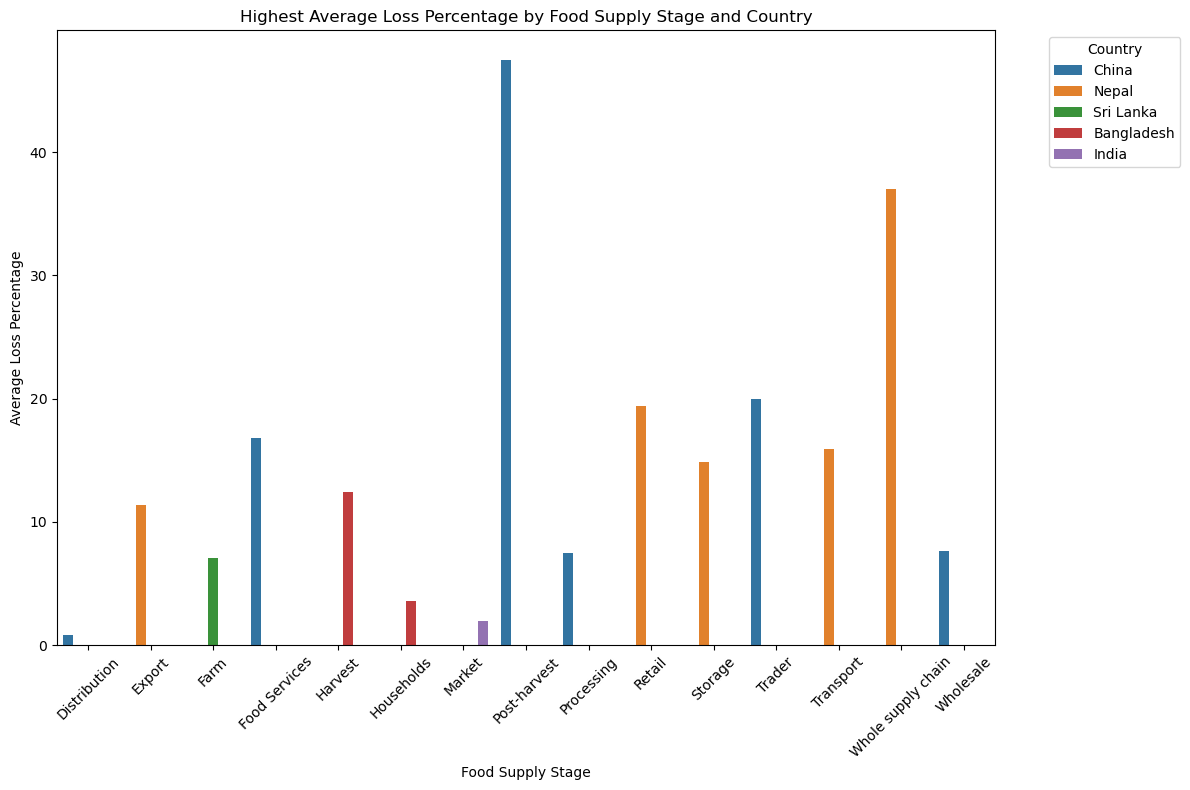

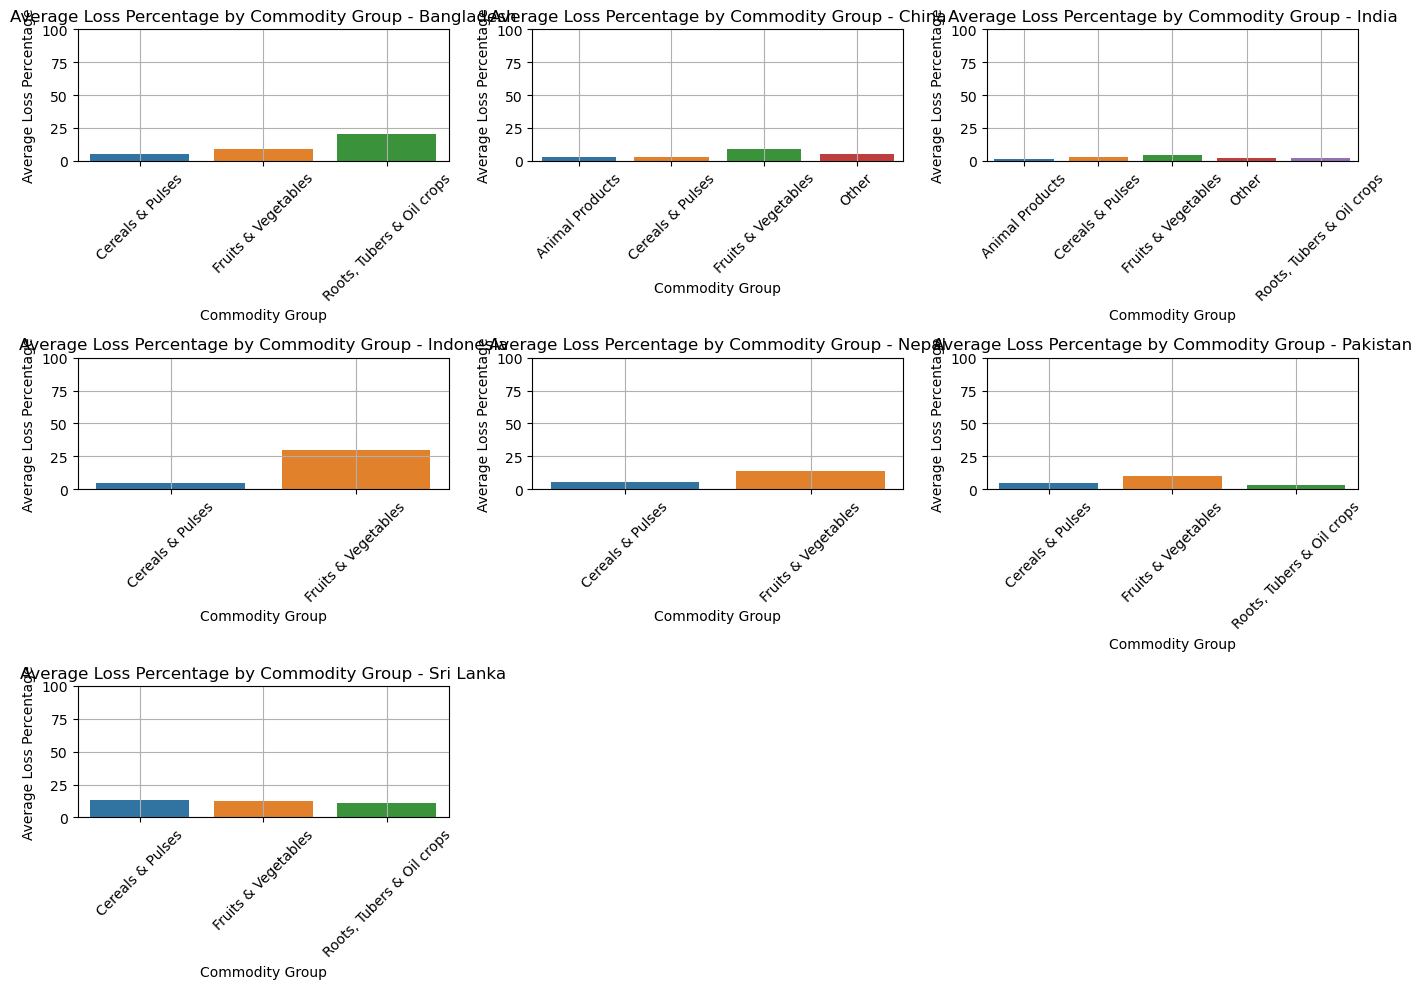

In [17]:
# Group by country and supply chain stage and calculate the mean loss percentage
avg_loss_per_country_stage = sub_df_cleaned.groupby(['country', 'food_supply_stage'])['loss_percentage'].mean().reset_index()

# Find the index of the maximum loss percentage for each food supply stage
idx = avg_loss_per_country_stage.groupby('food_supply_stage')['loss_percentage'].idxmax()

# Filter the original DataFrame to get the rows with the maximum loss percentages
highest_losses = avg_loss_per_country_stage.loc[idx]

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='food_supply_stage', y='loss_percentage', hue='country', data=highest_losses)
plt.title('Highest Average Loss Percentage by Food Supply Stage and Country')
plt.xlabel('Food Supply Stage')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=45)
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Group by country, commodity_group, and calculate the mean loss percentage
avg_loss_per_country_commodity = sub_df_cleaned.groupby(['country', 'commodity_group'])['loss_percentage'].mean().reset_index()

# Get unique countries for plotting
countries = avg_loss_per_country_commodity['country'].unique()

# Plotting each country separately using bar plots for each commodity group
plt.figure(figsize=(14, 10))

for idx, country in enumerate(countries, 1):
    # Filter data for the current country
    country_data = avg_loss_per_country_commodity[avg_loss_per_country_commodity['country'] == country]
    
    # Plot the bar chart for the current country
    plt.subplot(3, 3, idx)  # Adjust subplot arrangement as needed
    sns.barplot(x='commodity_group', y='loss_percentage', data=country_data)
    plt.title(f'Average Loss Percentage by Commodity Group - {country}')
    plt.xlabel('Commodity Group')
    plt.ylabel('Average Loss Percentage')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)  # Adjust y-axis limits if necessary
    plt.grid(True)

plt.tight_layout()
plt.show()




<Figure size 864x576 with 0 Axes>

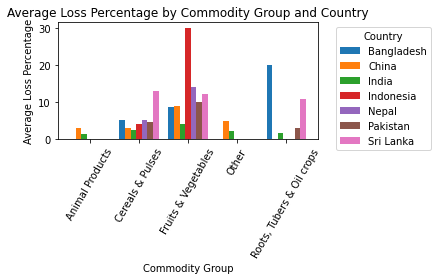

Average Loss Percentage by Commodity Group and Country:
       country            commodity_group  loss_percentage
0   Bangladesh           Cereals & Pulses         5.311894
1   Bangladesh        Fruits & Vegetables         8.789755
2   Bangladesh  Roots, Tubers & Oil crops        20.000000
3        China            Animal Products         2.983333
4        China           Cereals & Pulses         3.104124
5        China        Fruits & Vegetables         8.980694
6        China                      Other         4.930000
7        India            Animal Products         1.463529
8        India           Cereals & Pulses         2.657143
9        India        Fruits & Vegetables         4.229673
10       India                      Other         2.396522
11       India  Roots, Tubers & Oil crops         1.749622
12   Indonesia           Cereals & Pulses         4.277069
13   Indonesia        Fruits & Vegetables        30.000000
14       Nepal           Cereals & Pulses         5.166000


In [48]:
# Group by country and commodity group and calculate the mean loss percentage
avg_loss_per_country_commodity = sub_df_cleaned.groupby(['country', 'commodity_group'])['loss_percentage'].mean().reset_index()

# Pivot the DataFrame for better plotting
pivot_df = avg_loss_per_country_commodity.pivot(index='commodity_group', columns='country', values='loss_percentage')

# Plotting the results
plt.figure(figsize=(12, 8))
pivot_df.plot(kind='bar', width=0.8)
plt.title('Average Loss Percentage by Commodity Group and Country')
plt.xlabel('Commodity Group')
plt.ylabel('Average Loss Percentage')
plt.xticks(rotation=60)  # Adjust rotation angle if needed
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()


# Print the average loss percentage values
print("Average Loss Percentage by Commodity Group and Country:")
print(avg_loss_per_country_commodity)



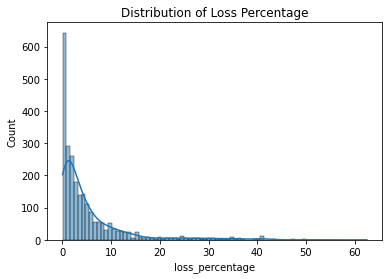

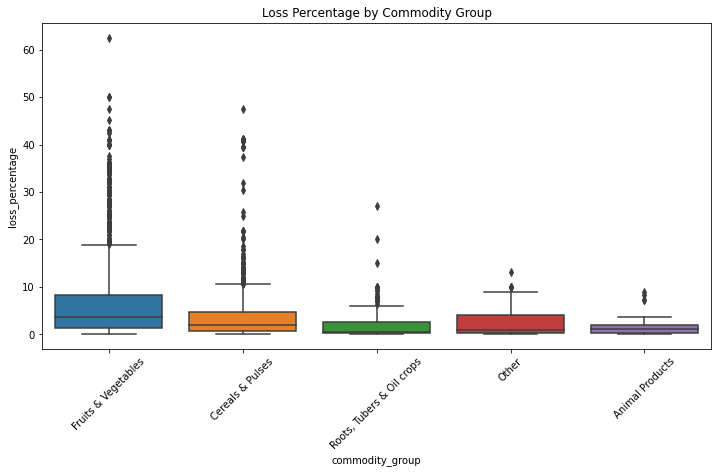

In [49]:
# Example of creating a new feature: total_loss_percentage by country and commodity
sub_df_cleaned['total_loss_percentage'] = sub_df_cleaned.groupby(['country', 'commodity'])['loss_percentage'].transform('mean')
# Histogram of loss percentage
sns.histplot(sub_df_cleaned['loss_percentage'], kde=True)
plt.title('Distribution of Loss Percentage')
plt.show()

# Box plot by commodity group
plt.figure(figsize=(12, 6))
sns.boxplot(x='commodity_group', y='loss_percentage', data=sub_df_cleaned)
plt.xticks(rotation=45)
plt.title('Loss Percentage by Commodity Group')
plt.show()

# Interactive Dashboard

In [27]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Provided data for food supply stages
countries = ['Bangladesh', 'Nepal', 'Sri Lanka', 'Pakistan', 'India', 'China', 'Indonesia']
stages = ['Distribution', 'Market', 'Households', 'Farm', 'Storage', 'Processing', 'Transport', 'Wholesale', 'Harvest', 'Retail', 'Food Services', 'Trader', 'Export', 'Whole supply chain', 'Post-harvest']
loss_percentages = [0.79, 1.94, 2.86, 2.94, 3.16, 3.26, 4.21, 5.64, 5.81, 6.89, 7.59, 7.95, 10.79, 12.05, 16.93]

# Create a DataFrame for food supply stages
data_fsc = {
    'country': countries * len(stages),
    'food_supply_stage': [stage for stage in stages for _ in range(len(countries))],
    'loss_percentage': loss_percentages * len(countries)
}

sub_df_cleaned_fsc = pd.DataFrame(data_fsc)

# Provided data for commodity groups
data_fw = {
    'country': ['Bangladesh', 'Bangladesh', 'Bangladesh', 'China', 'China', 'China', 'China', 'India', 'India', 'India', 'India', 'India', 'Indonesia', 'Indonesia', 'Nepal', 'Nepal', 'Pakistan', 'Pakistan', 'Pakistan', 'Sri Lanka', 'Sri Lanka', 'Sri Lanka'],
    'commodity_group': ['Cereals & Pulses', 'Fruits & Vegetables', 'Roots, Tubers & Oil crops', 'Animal Products', 'Cereals & Pulses', 'Fruits & Vegetables', 'Other', 'Animal Products', 'Cereals & Pulses', 'Fruits & Vegetables', 'Other', 'Roots, Tubers & Oil crops', 'Cereals & Pulses', 'Fruits & Vegetables', 'Cereals & Pulses', 'Fruits & Vegetables', 'Cereals & Pulses', 'Fruits & Vegetables', 'Roots, Tubers & Oil crops', 'Cereals & Pulses', 'Fruits & Vegetables', 'Roots, Tubers & Oil crops'],
    'loss_percentage': [5.311894, 8.789755, 20.000000, 2.983333, 3.104124, 8.980694, 4.930000, 1.463529, 2.657143, 4.229673, 2.396522, 1.749622, 4.277069, 30.000000, 5.166000, 14.048857, 4.791750, 10.166522, 3.190000, 12.968000, 12.179821, 10.808000]
}

# Create DataFrame for commodity groups
sub_df_cleaned_fw = pd.DataFrame(data_fw)

# Group by country and commodity group and calculate the mean loss percentage
avg_loss_per_country_commodity = sub_df_cleaned_fw.groupby(['country', 'commodity_group'])['loss_percentage'].mean().reset_index()

# Initialize the app
app = dash.Dash(__name__, external_stylesheets=['https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css'])

# App layout
app.layout = html.Div([
    html.H1("Food Loss Dashboard"),

    html.Div([
        html.Div([
            html.H2("Food Loss Percentage by Food Supply Stage and Country"),
            dcc.Dropdown(
                id='food_supply_stage_dropdown',
                options=[{'label': stage, 'value': stage} for stage in sub_df_cleaned_fsc['food_supply_stage'].unique()],
                value=sub_df_cleaned_fsc['food_supply_stage'].unique()[0],
                clearable=False
            ),
            dcc.Graph(id='bar_chart_fsc'),
            html.Div(id='avg_loss_text_fsc')
        ], style={'width': '48%', 'display': 'inline-block'}),
        
        html.Div([
            html.H2("Average Loss Percentage by Commodity Group and Country"),
            dcc.Dropdown(
                id='commodity_group_dropdown',
                options=[{'label': group, 'value': group} for group in avg_loss_per_country_commodity['commodity_group'].unique()],
                value=avg_loss_per_country_commodity['commodity_group'].unique()[0],
                clearable=False
            ),
            dcc.Graph(id='bar_chart_fw'),
            html.Div(id='avg_loss_text_fw')
        ], style={'width': '48%', 'display': 'inline-block'})
    ])
])

# Callback to update the bar chart and average loss text for food supply stages
@app.callback(
    [Output('bar_chart_fsc', 'figure'),
     Output('avg_loss_text_fsc', 'children')],
    [Input('food_supply_stage_dropdown', 'value')]
)
def update_chart_fsc(selected_stage):
    filtered_df = sub_df_cleaned_fsc[sub_df_cleaned_fsc['food_supply_stage'] == selected_stage]
    
    fig = px.bar(
        filtered_df,
        x='country',
        y='loss_percentage',
        title=f'Food Loss Percentage for {selected_stage}',
        labels={'loss_percentage': 'Loss Percentage', 'country': 'Country'},
        template='plotly_white',
        text='loss_percentage'
    )
    
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
    
    avg_loss = filtered_df['loss_percentage'].mean()
    avg_loss_text = f'Average loss percentage for {selected_stage}: {avg_loss:.2f}%'
    
    return fig, avg_loss_text

# Callback to update the bar chart and average loss text for commodity groups
@app.callback(
    [Output('bar_chart_fw', 'figure'),
     Output('avg_loss_text_fw', 'children')],
    [Input('commodity_group_dropdown', 'value')]
)
def update_chart_fw(selected_group):
    filtered_df = avg_loss_per_country_commodity[avg_loss_per_country_commodity['commodity_group'] == selected_group]
    
    fig = px.bar(
        filtered_df,
        x='country',
        y='loss_percentage',
        title=f'Average Loss Percentage for {selected_group}',
        labels={'loss_percentage': 'Loss Percentage', 'country': 'Country'},
        template='plotly_white',
        text='loss_percentage'
    )
    
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
    
    avg_loss = filtered_df['loss_percentage'].mean()
    avg_loss_text = f'Average loss percentage for {selected_group}: {avg_loss:.2f}%'
    
    return fig, avg_loss_text

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)


In [25]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Provided data
data = {
    'country': ['Bangladesh', 'Bangladesh', 'Bangladesh', 'China', 'China', 'China', 'China', 'India', 'India', 'India', 'India', 'India', 'Indonesia', 'Indonesia', 'Nepal', 'Nepal', 'Pakistan', 'Pakistan', 'Pakistan', 'Sri Lanka', 'Sri Lanka', 'Sri Lanka'],
    'commodity_group': ['Cereals & Pulses', 'Fruits & Vegetables', 'Roots, Tubers & Oil crops', 'Animal Products', 'Cereals & Pulses', 'Fruits & Vegetables', 'Other', 'Animal Products', 'Cereals & Pulses', 'Fruits & Vegetables', 'Other', 'Roots, Tubers & Oil crops', 'Cereals & Pulses', 'Fruits & Vegetables', 'Cereals & Pulses', 'Fruits & Vegetables', 'Cereals & Pulses', 'Fruits & Vegetables', 'Roots, Tubers & Oil crops', 'Cereals & Pulses', 'Fruits & Vegetables', 'Roots, Tubers & Oil crops'],
    'loss_percentage': [5.311894, 8.789755, 20.000000, 2.983333, 3.104124, 8.980694, 4.930000, 1.463529, 2.657143, 4.229673, 2.396522, 1.749622, 4.277069, 30.000000, 5.166000, 14.048857, 4.791750, 10.166522, 3.190000, 12.968000, 12.179821, 10.808000]
}

# Create DataFrame
sub_df_cleaned = pd.DataFrame(data)

# Group by country and commodity group and calculate the mean loss percentage
avg_loss_per_country_commodity = sub_df_cleaned.groupby(['country', 'commodity_group'])['loss_percentage'].mean().reset_index()

# Pivot the DataFrame for better plotting
pivot_df = avg_loss_per_country_commodity.pivot(index='commodity_group', columns='country', values='loss_percentage')

# Initialize the app
app = dash.Dash(__name__, external_stylesheets=['https://stackpath.bootstrapcdn.com/bootstrap/4.3.1/css/bootstrap.min.css'])

# App layout
app.layout = html.Div([
    html.H1("Average Loss Percentage by Commodity Group and Country"),
    dcc.Dropdown(
        id='commodity_group_dropdown',
        options=[{'label': group, 'value': group} for group in pivot_df.index.unique()],
        value=pivot_df.index.unique()[0],
        clearable=False
    ),
    dcc.Graph(id='bar_chart'),
    html.Div(id='avg_loss_text')
])

# Callback to update the bar chart and average loss text
@app.callback(
    [Output('bar_chart', 'figure'),
     Output('avg_loss_text', 'children')],
    [Input('commodity_group_dropdown', 'value')]
)
def update_chart(selected_group):
    filtered_df = avg_loss_per_country_commodity[avg_loss_per_country_commodity['commodity_group'] == selected_group]
    
    fig = px.bar(
        filtered_df,
        x='country',
        y='loss_percentage',
        title=f'Average Loss Percentage for {selected_group}',
        labels={'loss_percentage': 'Loss Percentage', 'country': 'Country'},
        template='plotly_white',
        text='loss_percentage'
    )
    
    fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
    
    avg_loss = filtered_df['loss_percentage'].mean()
    avg_loss_text = f'Average loss percentage for {selected_group}: {avg_loss:.2f}%'
    
    return fig, avg_loss_text

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)


         year     country  loss_percentage
0  2000-01-01       Nepal        12.202273
1  2001-01-01       China         8.935738
2  2001-01-01       India        14.287143
3  2001-01-01       Nepal        20.816667
4  2001-01-01    Pakistan        20.690000
5  2002-01-01       India        24.850000
6  2002-01-01   Indonesia        12.250000
7  2002-01-01       Nepal        10.000000
8  2002-01-01   Sri Lanka        12.344576
9  2003-01-01       India        19.226000
10 2003-01-01       Nepal        22.220000
11 2003-01-01    Pakistan        24.288000
12 2004-01-01  Bangladesh        17.160000
13 2004-01-01       India        22.550000
14 2004-01-01       Nepal        18.800000
15 2005-01-01  Bangladesh        19.090000
16 2005-01-01       India        14.275000
17 2005-01-01   Indonesia         0.370000
18 2005-01-01       Nepal        16.666667
19 2005-01-01    Pakistan        22.025000
20 2006-01-01       India         1.166817
21 2006-01-01   Indonesia         1.425833
22 2007-01-

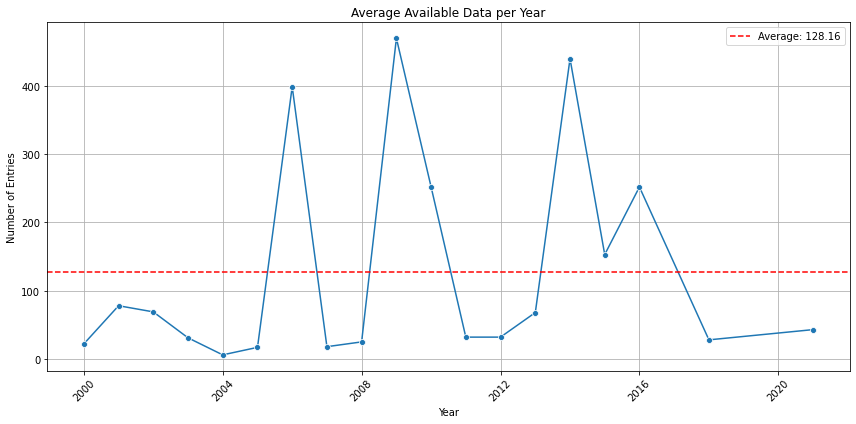

In [53]:
# Group by 'year' and 'country', then calculate mean loss_percentage
loss_by_year_country = sub_df_cleaned.groupby(['year', 'country'])['loss_percentage'].mean().reset_index()

# Display the aggregated data to verify
print(loss_by_year_country.head(50))


# Ensure 'year' column is in datetime format if it's not already
# sub_df_cleaned['year'] = pd.to_datetime(sub_df_cleaned['year'], format='%Y')

# Calculate the count of entries per year
yearly_data_count = sub_df_cleaned['year'].value_counts().sort_index()

# Create a DataFrame for visualization
yearly_data_df = pd.DataFrame({
    'year': yearly_data_count.index,
    'data_count': yearly_data_count.values
})

# Calculate the average data availability per year
avg_data_per_year = yearly_data_df['data_count'].mean()

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='data_count', data=yearly_data_df, marker='o')
plt.axhline(y=avg_data_per_year, color='r', linestyle='--', label=f'Average: {avg_data_per_year:.2f}')
plt.title('Average Available Data per Year')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [54]:
# Standardize the data
scaler = StandardScaler()
sub_df_standardized = pd.DataFrame(scaler.fit_transform(sub_df_cleaned.select_dtypes(include=[np.number])), 
                                   columns=sub_df_cleaned.select_dtypes(include=[np.number]).columns)

# Feature Engineering
# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
sub_df_poly = pd.DataFrame(poly.fit_transform(sub_df_standardized), columns=poly.get_feature_names(sub_df_standardized.columns))

# Combine with non-numeric columns
sub_df_final = pd.concat([sub_df_poly, sub_df_cleaned.select_dtypes(exclude=[np.number]).reset_index(drop=True)], axis=1)

print(f"Shape of sub_df_standardized: {sub_df_standardized.shape}")

Shape of sub_df_standardized: (2435, 2)



Correlation Matrix:
                                       loss_percentage  total_loss_percentage  \
loss_percentage                               1.000000               0.557506   
total_loss_percentage                         0.557506               1.000000   
loss_percentage^2                             0.843962               0.378466   
loss_percentage total_loss_percentage         0.564678               0.642063   
total_loss_percentage^2                       0.399281               0.716190   

                                       loss_percentage^2  \
loss_percentage                                 0.843962   
total_loss_percentage                           0.378466   
loss_percentage^2                               1.000000   
loss_percentage total_loss_percentage           0.606929   
total_loss_percentage^2                         0.361770   

                                       loss_percentage total_loss_percentage  \
loss_percentage                                    

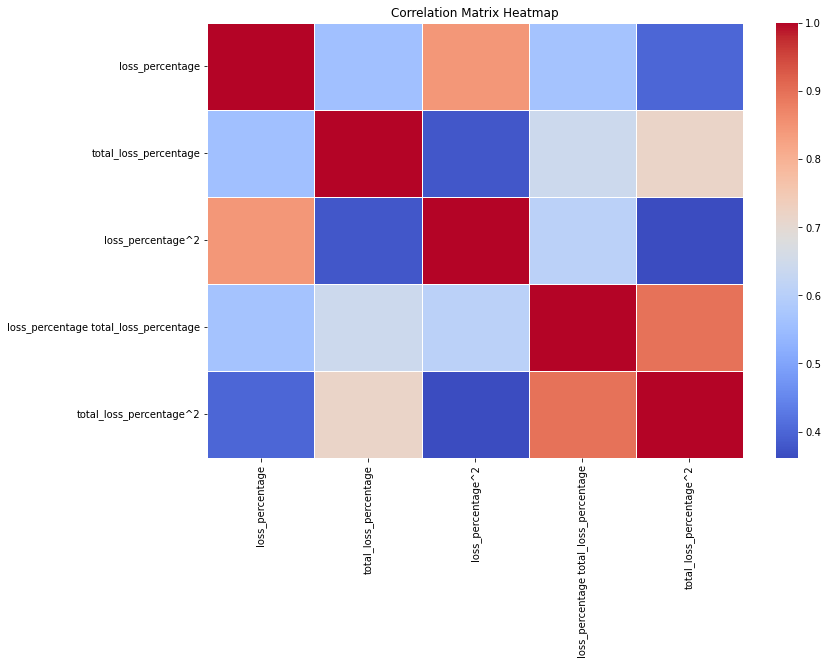

Shape of sub_df_standardized: (2435, 2)


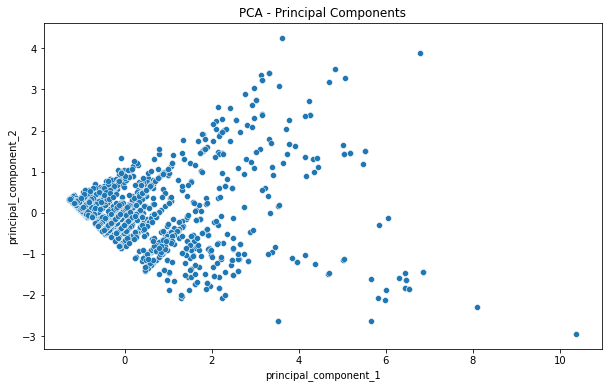

In [56]:
# Correlation Matrix
correlation_matrix = sub_df_final.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Check the shape of the standardized dataframe
n_samples, n_features = sub_df_standardized.shape
print(f"Shape of sub_df_standardized: {sub_df_standardized.shape}")

# Ensure that n_components is valid
n_components = min(2, n_samples, n_features)
if n_components < 2:
    print(f"Reducing the number of PCA components to {n_components} due to insufficient samples or features.")

# PCA to reduce dimensions
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(sub_df_standardized)
component_names = [f'principal_component_{i+1}' for i in range(n_components)]
sub_df_pca = pd.DataFrame(data=principal_components, columns=component_names)

# Plot PCA
plt.figure(figsize=(10, 6))
if n_components == 2:
    sns.scatterplot(x='principal_component_1', y='principal_component_2', data=sub_df_pca)
    plt.title('PCA - Principal Components')
elif n_components == 1:
    sns.scatterplot(x='principal_component_1', y=[0]*len(sub_df_pca), data=sub_df_pca)
    plt.title('PCA - Principal Component 1')
else:
    print("Insufficient components to plot PCA.")

plt.show()

# Modeling and Analysis

In [60]:
# Feature Selection
features = sub_df_cleaned.drop(columns=['loss_percentage'])
target = sub_df_cleaned['loss_percentage']

# Preprocessing
numerical_features = features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = features.select_dtypes(exclude=[np.number]).columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create a pipeline that includes the preprocessor and a model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 30.89361887724073
R-squared: 0.4303140080681287


Linear Regression - Mean Squared Error: 30.89361887724073, R-squared: 0.4303140080681287
Decision Tree - Mean Squared Error: 25.031976084188916, R-squared: 0.5384041545213201
Random Forest - Mean Squared Error: 25.435008736209962, R-squared: 0.5309721324892009


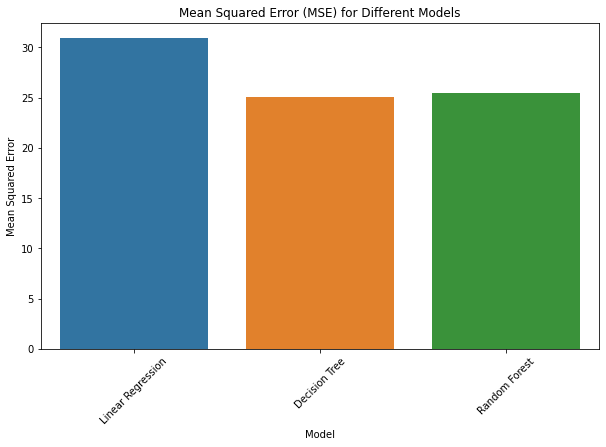

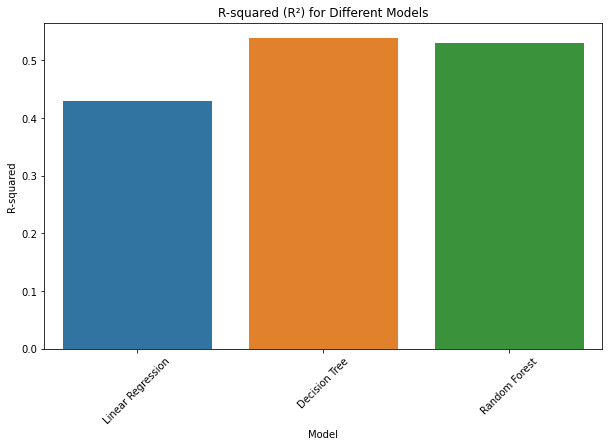

In [61]:
# Feature Selection
features = sub_df_cleaned.drop(columns=['loss_percentage'])
target = sub_df_cleaned['loss_percentage']

# Preprocessing
numerical_features = features.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = features.select_dtypes(exclude=[np.number]).columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[model_name] = {'MSE': mse, 'R-squared': r2}

# Display results
for model_name, metrics in results.items():
    print(f"{model_name} - Mean Squared Error: {metrics['MSE']}, R-squared: {metrics['R-squared']}")
    

# Visualize MSE and R-squared for each model
metrics_df = pd.DataFrame(results).T

# Bar plot for Mean Squared Error
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y='MSE', data=metrics_df)
plt.title('Mean Squared Error (MSE) for Different Models')
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

# Bar plot for R-squared
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y='R-squared', data=metrics_df)
plt.title('R-squared (R²) for Different Models')
plt.ylabel('R-squared')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

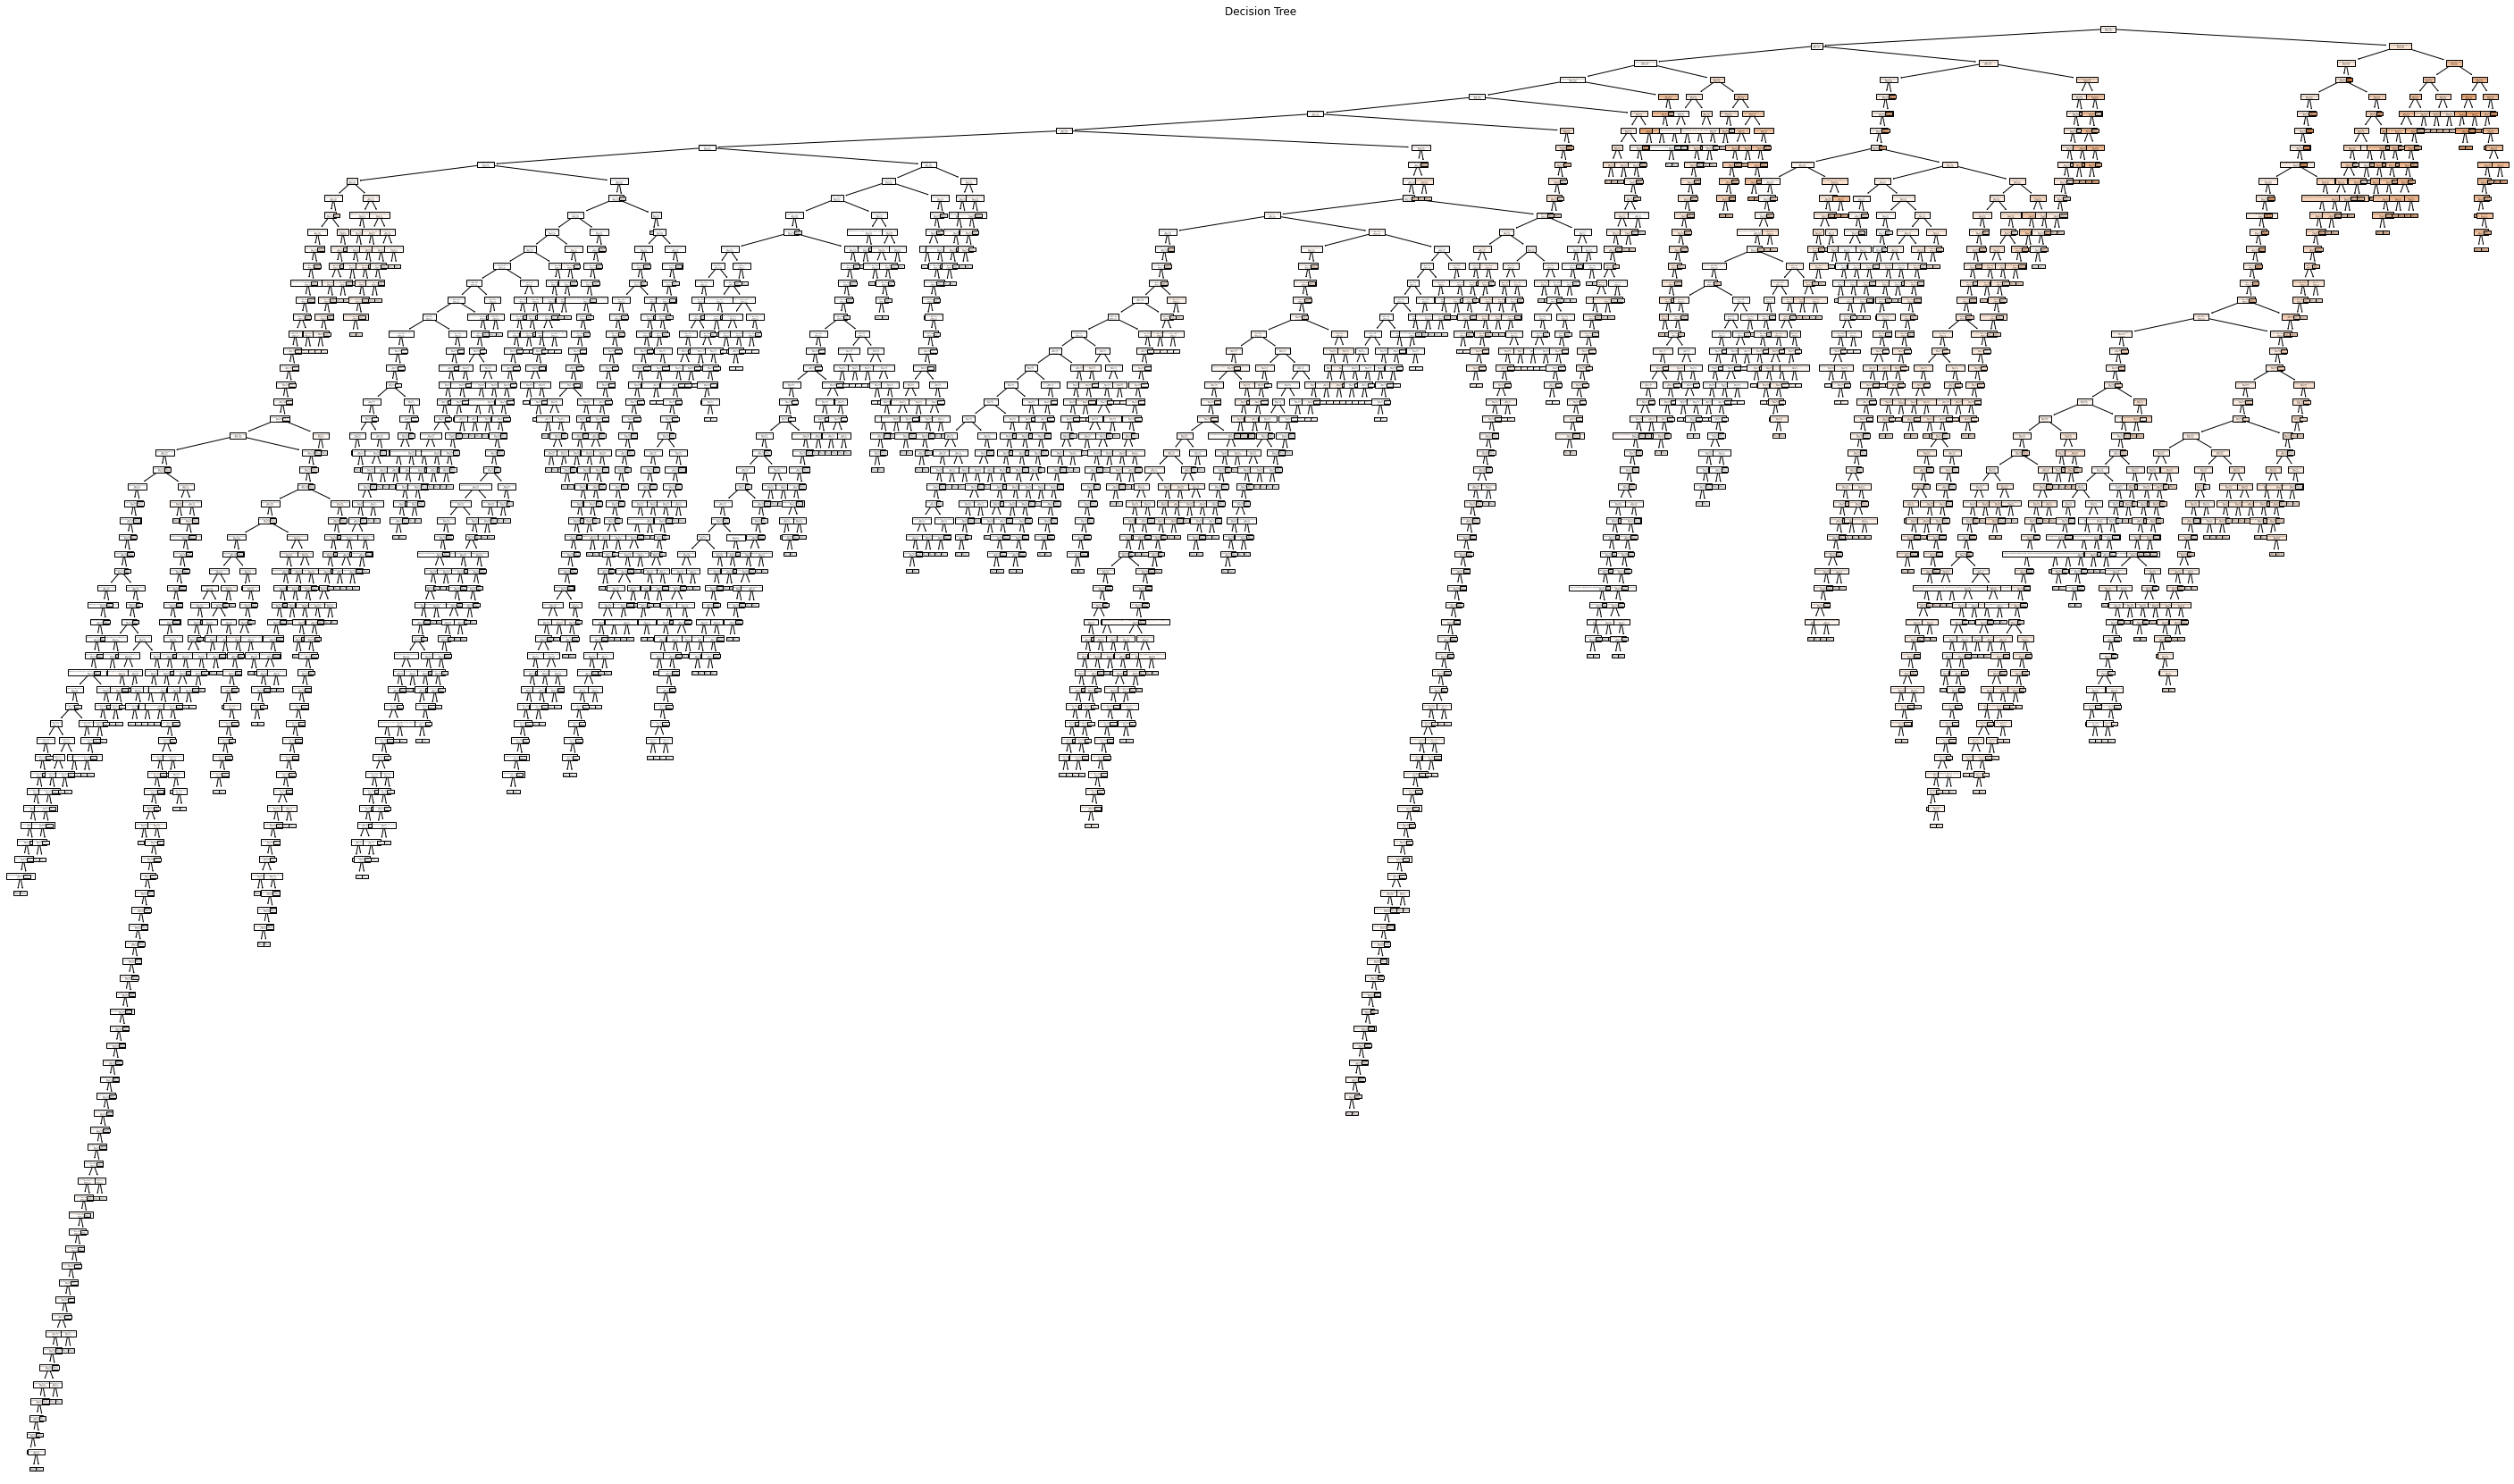

In [62]:
# Visualize the Decision Tree
# Extract the decision tree regressor from the pipeline
decision_tree_model = models['Decision Tree']
decision_tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                         ('regressor', decision_tree_model)])
decision_tree_pipeline.fit(X_train, y_train)

plt.figure(figsize=(50, 30))
plot_tree(decision_tree_model, filled=True, feature_names=numerical_features + list(preprocessor.transformers_[1][1]['onehot'].get_feature_names(categorical_features)))
plt.title("Decision Tree")
plt.show()